# qa-nlp
Question answering neural model based on the SQuAD dataset.

Authors:
- Lorenzo Mario Amorosa
- Andrea Espis
- Mattia Orlandi
- Giacomo Pinardi

## 0. Environment setup

In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
# Library to read json
import json

# Numeric and data manipulation tools
import pandas as pd
import numpy as np
import random

# Deep learning framework
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Natural language tools
import nltk
from nltk.tokenize import TreebankWordTokenizer
import gensim
import gensim.downloader as gloader

# Other tools
from tqdm.notebook import tqdm
from collections import OrderedDict, Counter
from time import time
from itertools import zip_longest

# automatic mixed precision training:
from torch.cuda.amp import autocast 
from torch.cuda.amp import GradScaler

# Type hint
from typing import Optional, Callable, Tuple, Dict, List, Union

nltk.download('punkt')
nltk.download('stopwords')

# from sklearn.model_selection import train_test_split

# Use GPU acceleration if possible
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using this device:', DEVICE)

if not(torch.cuda.is_available()):
    raise Exception('Switch to runtime GPU, otherwise the code won\'t work properly')

Using this device: cuda:0


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\97and\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\97and\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
# Set seed for reproducibility
def fix_random(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(42)

In [21]:
# Use GPU acceleration if possible
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("using this device:", DEVICE)

# Define special tokens
PAD = '<PAD>'
UNK = '<UNK>'

using this device: cuda:0


In [22]:
# Lambda for computing the mean of a list
mean: Callable[[List[float]], float] = lambda l: sum(l) / len(l)

# Lambda for transforming a list of tuples into a tuple of lists
to_tuple_of_lists: Callable[[List[Tuple]], Tuple[List]] = lambda list_of_tuples: tuple(map(list, zip(*list_of_tuples)))

# Lambda for transforming a tuple of lists into a list of tuples
to_list_of_tuples: Callable[[Tuple[List]], List[Tuple]] = lambda tuple_of_lists: list(zip(*tuple_of_lists))

# Lambda for iterating with batches (if the length of the sequences does not match with the batch size, tuples of empty lists are appended)
batch_iteration: Callable[[List[Tuple]], zip] = lambda data, batch_size: zip_longest(*[iter(data)] * batch_size, fillvalue=([], [], []))

## 1. Dataset preparation

In [23]:
"""
json structure:

data []
|---title
|---paragraphs []
|   |---context
|   |---qas []
|   |   |---answers []
|   |   |   |---answer_start
|   |   |   |---text
|   |   |---question
|   |   |---id
version

"""

filename = 'training_set.json'

with open(filename, 'r') as f:
    raw_data = f.readlines()[0]

parsed_data = json.loads(raw_data)['data']

context_list = []
context_index = -1
paragraph_index = -1

dataset = {'paragraph_index': [], 'context_index': [], 'question': [], 'answer_start': [], 'answer_end': [], 'answer_text': []}

for i in range(len(parsed_data)):
    paragraph_index += 1
    for j in range(len(parsed_data[i]['paragraphs'])):
        context_list.append(parsed_data[i]['paragraphs'][j]['context'])
        context_index += 1

        for k in range(len(parsed_data[i]['paragraphs'][j]['qas'])):
            question = parsed_data[i]['paragraphs'][j]['qas'][k]['question']

            for l in range(len(parsed_data[i]['paragraphs'][j]['qas'][k]['answers'])): 
                answer_start = parsed_data[i]['paragraphs'][j]['qas'][k]['answers'][l]['answer_start']
                answer_text = parsed_data[i]['paragraphs'][j]['qas'][k]['answers'][l]['text']

                answer_end = answer_start + len(answer_text)

                dataset['paragraph_index'].append(paragraph_index)
                dataset['context_index'].append(context_index)
                dataset['question'].append(question)
                dataset['answer_start'].append(answer_start)
                dataset['answer_end'].append(answer_end)
                dataset['answer_text'].append(answer_text)

df = pd.DataFrame.from_dict(dataset)

df.head()

,paragraph_index,context_index,question,answer_start,answer_end,answer_text
0,0,0,To whom did the Virgin Mary allegedly appear i...,515,541,Saint Bernadette Soubirous
1,0,0,What is in front of the Notre Dame Main Building?,188,213,a copper statue of Christ
2,0,0,The Basilica of the Sacred heart at Notre Dame...,279,296,the Main Building
3,0,0,What is the Grotto at Notre Dame?,381,420,a Marian place of prayer and reflection
4,0,0,What sits on top of the Main Building at Notre...,92,126,a golden statue of the Virgin Mary


In [24]:
# L'unica cosa che si potrebbe rimuovere è la fonetica, ma è poco presente. Inoltre facendolo bisognerebbe aggiornare gli indici

# Some examples of contexts and questions:
for i in range(0, 4000, 100):
    # print('Title:   ', title_list[df['title_index'][i]])
    print('Context: ', context_list[df['context_index'][i]])
    print('Question:', df['question'][i], "\n")

Context:  Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.
Question: To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France? 

Context:  One of the main driving forces in the growth of the University was its football team, the Notre Dame Fighting Irish. Knute Rockne became head coach in 1918. Under Rockne, the Irish would post a record

In [25]:
# Define split ratios
test_ratio = 0.2
val_ratio = 0.2

# Build array of paragraphs indexes and shuffle them
paragraph_indexes = df['paragraph_index'].unique()
np.random.shuffle(paragraph_indexes)
n_samples = len(paragraph_indexes)

# Reserve indexes for test set
test_size = int(test_ratio * n_samples)
train_val_size = n_samples - test_size
test_indexes = paragraph_indexes[-test_size:]
# Reserve indexes for validation set
val_size = int(val_ratio * train_val_size)
train_size = train_val_size - val_size
val_indexes = paragraph_indexes[-(test_size + val_size):-test_size]
# Reserve indexes for training set
train_indexes = paragraph_indexes[:train_size]

assert train_size == len(train_indexes), 'Something went wrong with train set slicing'
assert val_size == len(val_indexes), 'Something went wrong with val set slicing'
assert test_size == len(test_indexes), 'Something went wrong with test set slicing'

print('Number of train paragraphs:', train_size)
print('Number of validation paragraphs:', val_size)
print('Number of test paragraphs:', test_size)

# Split dataframe
df_train = df[np.in1d(df['paragraph_index'], train_indexes)]
df_val = df[np.in1d(df['paragraph_index'], val_indexes)]
df_test = df[np.in1d(df['paragraph_index'], test_indexes)]

print('\nNumber of train samples:', len(df_train))
print('Number of validation samples:', len(df_val))
print('Number of test samples:', len(df_test))

Number of train paragraphs: 284
Number of validation paragraphs: 70
Number of test paragraphs: 88

Number of train samples: 57451
Number of validation samples: 12921
Number of test samples: 17227


## 2. Embeddings

In [9]:
print('Downloading GloVe model...')
emb_dim = 50
glove_model = gloader.load('glove-wiki-gigaword-' + str(emb_dim))
print('\nDownload completed.')


Download completed.


In [26]:
if True:
    df_train = df_train[:100]
    df_val = df_val[:30]
    df_test = df_test[:10]

In [27]:
def tokenize_corpus(df: pd.DataFrame, context_list: List[str]):
    twt = TreebankWordTokenizer()
    
    t_start = time()
    # Retrieve contexts
    contexts = df['context_index'].apply(lambda x: context_list[x])
    # Tokenize both contexts and queries
    x_ctx = contexts.apply(lambda x: twt.tokenize(x)).tolist()
    x_qry = df['question'].apply(lambda x: twt.tokenize(x)).tolist()
    # Get indexes to start_end characters
    y_char = [(start, end) for start, end in zip(df['answer_start'].tolist(), df['answer_end'].tolist())]
    # Get spans of tokens
    spans_list = contexts.apply(lambda x: twt.span_tokenize(x)).tolist()
    # Convert indexes s.t. the point to start/end tokens
    y = []
    for spans, (char_start, char_end) in zip(spans_list, y_char):
        token_start, token_end = None, None
        for i, span in enumerate(spans):
            if span[0] <= char_start <= span[1]:
                token_start = i
            if span[0] <= char_end <= span[1]:
                token_end = i
        y.append((token_start, token_end))
    print(f'[{time() - t_start:.3f} s]')
    
    return x_ctx, x_qry, y

def build_vocabulary(corpus: List[List[str]],
                     old_word_listing: Optional[List[str]] = None) -> (Dict[int, str], Dict[int, str], List[str]):
    flat_tokens = [x for sub in corpus for x in sub]
    
    if old_word_listing is None:  # standard case
        word_listing = [PAD] + list(OrderedDict.fromkeys(flat_tokens))
    else:  # case in which we extend an already existing vocabulary
        word_listing = list(OrderedDict.fromkeys(old_word_listing + flat_tokens))
        
    idx_to_word = {i: w for i, w in enumerate(word_listing)}
    word_to_idx = {w: i for i, w in enumerate(word_listing)}

    return idx_to_word, word_to_idx, word_listing

# Tokenize corpus
print('Tokenizing training corpus...', end=' ')
X_trainC, X_trainQ, Y_train = tokenize_corpus(df_train, context_list)
train_corpus = X_trainC + X_trainQ

print('Tokenizing validation corpus...', end=' ')
X_valC, X_valQ, Y_val = tokenize_corpus(df_val, context_list)
val_corpus = X_valC + X_valQ

print('Tokenizing test corpus...', end=' ')
X_testC, X_testQ, Y_test = tokenize_corpus(df_test, context_list)
test_corpus = X_testC + X_testQ

# Get word and char mappings for each set
train_i2w, train_w2i, train_wl = build_vocabulary(train_corpus)
val_i2w, val_w2i, val_wl = build_vocabulary(val_corpus, train_wl)
test_i2w, test_w2i, test_wl = build_vocabulary(test_corpus, val_wl)

print('-' * 50)
print('Words in training set:', len(train_wl))
print('Words in validation set:', len(val_wl))
print('Words in test set:', len(test_wl))

Tokenizing training corpus... [0.084 s]
Tokenizing validation corpus... [0.024 s]
Tokenizing test corpus... [0.009 s]
--------------------------------------------------
Words in training set: 1398
Words in validation set: 1614
Words in test set: 1681


In [28]:
train_oov_words = [word for word in train_wl if word not in glove_model.vocab and word != PAD]
val_oov_words = [word for word in val_wl if word not in glove_model.vocab and word != PAD]
test_oov_words = [word for word in test_wl if word not in glove_model.vocab and word != PAD]

print(f'Total OOV terms in training set: {len(train_oov_words)} ({float(len(train_oov_words)) / len(train_wl) * 100:.2f}%)')
print(f'Total OOV terms in validation set: {len(val_oov_words)} ({float(len(val_oov_words)) / len(val_wl) * 100:.2f}%)')
print(f'Total OOV terms in test set: {len(test_oov_words)} ({float(len(test_oov_words)) / len(test_wl) * 100:.2f}%)')

Total OOV terms in training set: 460 (32.90%)
Total OOV terms in validation set: 512 (31.72%)
Total OOV terms in test set: 540 (32.12%)


In [29]:
def build_word_embedding_matrix(embedding_model: gensim.models.keyedvectors.Word2VecKeyedVectors,
                                word_to_idx: Dict[str, int],
                                oov_words: List[str],
                                old_word_embedding_matrix: Optional[np.ndarray] = None):
    # Initialize embedding matrix with all zeros
    embedding_matrix = np.zeros((len(word_to_idx), embedding_model.vector_size))
    
    # Analyze embeddings to get mean and standard deviation
    mean_list, std_list = [], []
    for word in tqdm(word_to_idx.keys(), leave=False):
        if word not in oov_words and word != PAD:
            embed = embedding_model[word]
            # Compute mean and std
            mean_list.append(np.mean(embed))
            std_list.append(np.std(embed))

    embedding_mean = mean(mean_list)
    embedding_std = mean(std_list)

    for word, idx in tqdm(word_to_idx.items(), leave=False):
        # If word is PAD no action is performed (it will be assigned the zero vector)
        if word not in oov_words and word != PAD:
            embedding_matrix[idx] = embedding_model[word]
        elif word in oov_words:
            oov_idx = word_to_idx[word]
            if old_word_embedding_matrix is None or oov_idx >= len(old_word_embedding_matrix):
                embedding_matrix[idx] = np.random.normal(loc=embedding_mean, scale=embedding_std, size=embedding_model.vector_size)
            else:
                embedding_matrix[idx] = old_word_embedding_matrix[oov_idx]
            
    return embedding_matrix

# Build word embedding matrix based only on the training set (for training)
train_emb_mtx = build_word_embedding_matrix(glove_model, train_w2i, train_oov_words)
print('Shape of word embedding matrix (training set):', train_emb_mtx.shape)

# Build word embedding matrix based on training + validation set (for validation)
val_emb_mtx = build_word_embedding_matrix(glove_model, val_w2i, val_oov_words, train_emb_mtx)
print('Shape of word embedding matrix (validation set):', val_emb_mtx.shape)

# Build word embedding matrix based on training + validation + test set (for test)
test_emb_mtx = build_word_embedding_matrix(glove_model, test_w2i, test_oov_words, val_emb_mtx)
print('Shape of word embedding matrix (test set):', test_emb_mtx.shape)

Shape of word embedding matrix (training set): (1398, 50)


Shape of word embedding matrix (validation set): (1614, 50)


Shape of word embedding matrix (test set): (1681, 50)


In [30]:
def build_char_embedding_matrix(corpus: List[str],
                                enc_dim: Optional[int] = 100):
    # Flatten to obtain single characters
    flat_chars = [c for sent in corpus for word in sent for c in word]
    
    # Sort characters by occurrences
    unique_chars = Counter(flat_chars)
    char_listing = sorted(unique_chars, key=unique_chars.get, reverse=True)
    # Select only the enc_dim most frequent ones
    if len(char_listing) > enc_dim - 1:
        char_listing = char_listing[:enc_dim - 1]
    char_listing = [PAD] + char_listing + [UNK]  # add PAD and UNK tokens
    
    idx_to_char = {i: c for i, c in enumerate(char_listing)}
    char_to_idx = {c: i for i, c in enumerate(char_listing)}
    
    # Create one-hot vectors, reserving the last one for UNK (0...0, 1)
    one_hot_chars = np.zeros((len(char_listing) - 1, enc_dim))
    np.fill_diagonal(one_hot_chars, 1)
    one_hot_chars = np.vstack([np.zeros((1, enc_dim)), one_hot_chars])  # stack zero vector on top for PAD
    
    return idx_to_char, char_to_idx, char_listing, one_hot_chars

# Build char embedding matrix based only on the training set, and use it for validation and test too:
# in fact, we can assume that characters appear uniformly in the three splits;
# for those rare case in which this does not happen, we assign the UNK vector
i2c, c2i, cl, char_emb_mtx = build_char_embedding_matrix(train_corpus)
print('Shape of char embedding matrix (training set):', char_emb_mtx.shape)

Shape of char embedding matrix (training set): (80, 100)


## 3. Training


In [31]:
from utils.train_utils import training_loop

In [32]:
from model.bidaf import BiDAF
from model.char_embedder import CharEmbedder
from model.word_embedder import WordEmbedder
from model.tensor_maker import TensorMaker

char_embedder = CharEmbedder(init_emb = torch.FloatTensor(char_emb_mtx),
                             out_char_emb_dim = emb_dim,
                             hidden_dim = 64,
                             input_channels = 1,
                             output_channels = 100,
                             kernel_height = 5,
                             trainable = False)

train_word_embedder = WordEmbedder(init_emb = torch.FloatTensor(train_emb_mtx))
val_word_embedder = WordEmbedder(init_emb = torch.FloatTensor(val_emb_mtx))

model_bidaf = BiDAF(char_embedder, train_word_embedder, val_word_embedder, use_constraint = False).to(DEVICE)

train_tensor_maker = TensorMaker(train_w2i, c2i, device=DEVICE)
val_tensor_maker = TensorMaker(val_w2i, c2i, device=DEVICE)

In [33]:
from utils.bidaf_loss import bidaf_loss

train_data = to_list_of_tuples((X_trainC, X_trainQ, Y_train))
val_data = to_list_of_tuples((X_valC, X_valQ, Y_val))

EP = 10
BS = 32

optimizer = torch.optim.Adam(model_bidaf.parameters(), lr=5e-3)
#optimizer = torch.optim.Adadelta(model_bidaf.parameters(), lr=0.5, rho=0.999, eps=1e-06, weight_decay=0) # slower in time and in loss
criterion = bidaf_loss

history = training_loop(model=model_bidaf,
                        train_data=train_data,
                        optimizer=optimizer,
                        epochs=EP,
                        batch_size=BS,
                        criterion=criterion,
                        train_tensor_maker=train_tensor_maker,
                        val_tensor_maker=val_tensor_maker,
                        val_data=val_data,
                        early_stopping=False,
                        patience = 15,
                        checkpoint_path='bidaf_baseline.pt')

----------------------------------------------------------------------------------------------------
Epoch 1/10


Start_pred: 120, End_pred: 118, Start_true: 104, End_true: 107
	Loss: 10.92404 - Distance start: 59.57 - Distance end: 62.28exact_score: 0.20 f1_score: 0.01[Time elapsed: 0.54 s]


Start (p): 101, End (p): 106, Start (T): 17, End (T): 17
	Validation loss: 10.15693 - Distance start: 38.03 - Distance end: 67.37 exact_score: 0.00 f1_score: 0.02[Time elapsed: 0.07 s]
----------------------------------------------------------------------------------------------------
Epoch 2/10


Start_pred: 74, End_pred: 74, Start_true: 7, End_true: 8
	Loss: 10.70302 - Distance start: 56.97 - Distance end: 51.91exact_score: 0.18 f1_score: 0.00[Time elapsed: 0.47 s]


Start (p): 18, End (p): 68, Start (T): 70, End (T): 76
	Validation loss: 9.78518 - Distance start: 40.20 - Distance end: 39.83 exact_score: 0.00 f1_score: 0.05[Time elapsed: 0.07 s]
----------------------------------------------------------------------------------------------------
Epoch 3/10


Start_pred: 3, End_pred: 152, Start_true: 98, End_true: 99
	Loss: 9.95530 - Distance start: 47.23 - Distance end: 46.39exact_score: 0.13 f1_score: 0.03[Time elapsed: 0.45 s]


Start (p): 0, End (p): 8, Start (T): 87, End (T): 88
	Validation loss: 9.58155 - Distance start: 50.73 - Distance end: 45.93 exact_score: 0.00 f1_score: 0.08[Time elapsed: 0.07 s]
----------------------------------------------------------------------------------------------------
Epoch 4/10


Start_pred: 0, End_pred: 1, Start_true: 67, End_true: 69
	Loss: 9.52014 - Distance start: 59.27 - Distance end: 54.23exact_score: 0.03 f1_score: 0.05[Time elapsed: 0.56 s]


Start (p): 0, End (p): 33, Start (T): 131, End (T): 141
	Validation loss: 9.29256 - Distance start: 52.73 - Distance end: 31.83 exact_score: 0.00 f1_score: 0.08[Time elapsed: 0.07 s]
----------------------------------------------------------------------------------------------------
Epoch 5/10


Start_pred: 2, End_pred: 2, Start_true: 67, End_true: 68
	Loss: 8.82438 - Distance start: 59.52 - Distance end: 56.76exact_score: 0.02 f1_score: 0.06[Time elapsed: 0.47 s]


Start (p): 0, End (p): 30, Start (T): 56, End (T): 57
	Validation loss: 9.30004 - Distance start: 72.47 - Distance end: 33.23 exact_score: 0.03 f1_score: 0.04[Time elapsed: 0.07 s]
----------------------------------------------------------------------------------------------------
Epoch 6/10


Start_pred: 6, End_pred: 119, Start_true: 55, End_true: 57
	Loss: 8.32543 - Distance start: 54.35 - Distance end: 56.67exact_score: 0.07 f1_score: 0.04[Time elapsed: 0.53 s]


Start (p): 0, End (p): 33, Start (T): 76, End (T): 77
	Validation loss: 9.36175 - Distance start: 59.60 - Distance end: 33.87 exact_score: 0.17 f1_score: 0.04[Time elapsed: 0.08 s]
----------------------------------------------------------------------------------------------------
Epoch 7/10


Start_pred: 32, End_pred: 33, Start_true: 62, End_true: 63
	Loss: 8.55540 - Distance start: 48.51 - Distance end: 46.26exact_score: 0.08 f1_score: 0.06[Time elapsed: 0.50 s]


Start (p): 0, End (p): 33, Start (T): 76, End (T): 77
	Validation loss: 9.55254 - Distance start: 67.60 - Distance end: 31.90 exact_score: 0.20 f1_score: 0.03[Time elapsed: 0.07 s]
----------------------------------------------------------------------------------------------------
Epoch 8/10


Start_pred: 25, End_pred: 26, Start_true: 86, End_true: 88
	Loss: 7.51927 - Distance start: 47.84 - Distance end: 47.30exact_score: 0.11 f1_score: 0.07[Time elapsed: 0.48 s]


Start (p): 33, End (p): 33, Start (T): 42, End (T): 45
	Validation loss: 9.59197 - Distance start: 63.90 - Distance end: 31.90 exact_score: 0.20 f1_score: 0.00[Time elapsed: 0.07 s]
----------------------------------------------------------------------------------------------------
Epoch 9/10


Start_pred: 42, End_pred: 7, Start_true: 61, End_true: 61
	Loss: 7.23195 - Distance start: 44.13 - Distance end: 47.87exact_score: 0.11 f1_score: 0.07[Time elapsed: 0.48 s]


Start (p): 12, End (p): 33, Start (T): 15, End (T): 32
	Validation loss: 9.75455 - Distance start: 64.80 - Distance end: 33.87 exact_score: 0.20 f1_score: 0.03[Time elapsed: 0.06 s]
----------------------------------------------------------------------------------------------------
Epoch 10/10


Start_pred: 14, End_pred: 90, Start_true: 89, End_true: 91
	Loss: 6.71447 - Distance start: 44.62 - Distance end: 43.39exact_score: 0.13 f1_score: 0.08[Time elapsed: 0.45 s]


Start (p): 126, End (p): 19, Start (T): 70, End (T): 76
	Validation loss: 9.79962 - Distance start: 57.07 - Distance end: 33.87 exact_score: 0.20 f1_score: 0.03[Time elapsed: 0.08 s]


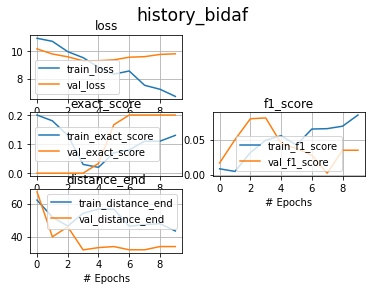

In [41]:
import matplotlib.pyplot as plt
def plot_history(history, title, save = True):    
    # this function is simply used to plot and save the image (and the dictionary) about the train and val loss and accuracy during the training
    fig = plt.figure()
    fig.figsize=(10, 100)
    plt.suptitle(title, size='xx-large')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    ax1 = fig.add_subplot(3,2,1)
    ax1.plot(history['loss'], label='train_loss')
    ax1.plot(history['val_loss'], label='val_loss')
    ax1.set_title('loss')
    ax1.set(xlabel='# Epochs')
    ax1.grid()
    ax1.legend();

    
    ax1 = fig.add_subplot(3,2,3)
    ax1.plot(history['exact_score'], label='train_exact_score')
    ax1.plot(history['val_exact_score'], label='val_exact_score')
    ax1.set_title('exact_score')
    ax1.set(xlabel='# Epochs')
    ax1.grid()
    ax1.legend();
    
    ax1 = fig.add_subplot(3,2,4)
    ax1.plot(history['f1_score'], label='train_f1_score')
    ax1.plot(history['val_f1_score'], label='val_f1_score')
    ax1.set_title('f1_score')
    ax1.set(xlabel='# Epochs')
    ax1.grid()
    ax1.legend();
    
    
    ax2 = fig.add_subplot(3,2,5)
    ax2.plot(history['distance_end'], label='train_distance_end')
    ax2.plot(history['val_distance_end'], label='val_distance_end')
    ax2.set_title('distance_end')
    ax2.set(xlabel='# Epochs')
    ax2.grid()
    ax2.legend();
    plt.show()
    
    ax2 = fig.add_subplot(3,2,6)
    ax2.plot(history['distance_start'], label='train_distance_start')
    ax2.plot(history['val_distance_start'], label='val_distance_start')
    ax2.set_title('distance_start')
    ax2.set(xlabel='# Epochs')
    ax2.grid()
    ax2.legend();
    plt.show()


    if save:
        fig_title = "_".join( title.split() )
        fig.savefig("figure_"+fig_title+'.png')
        
        # save dictionary:  
        f = open("dict_"+ fig_title +".txt","w")
        f.write(str(history))
        f.close()
        
plot_history(history, "history_bidaf")

NameError: name 'fig' is not defined

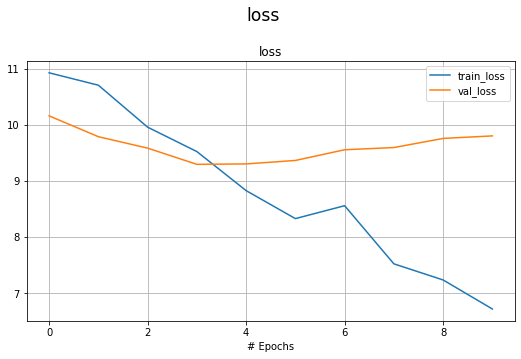

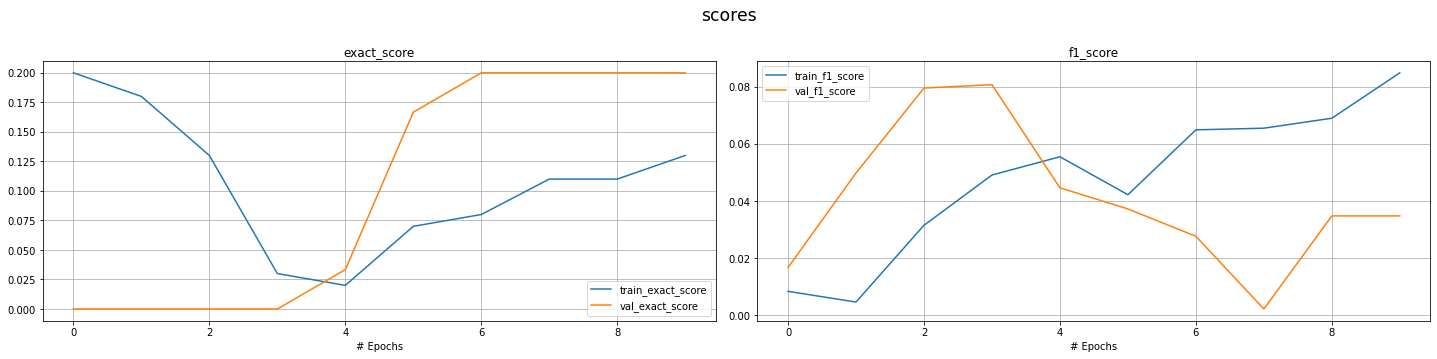

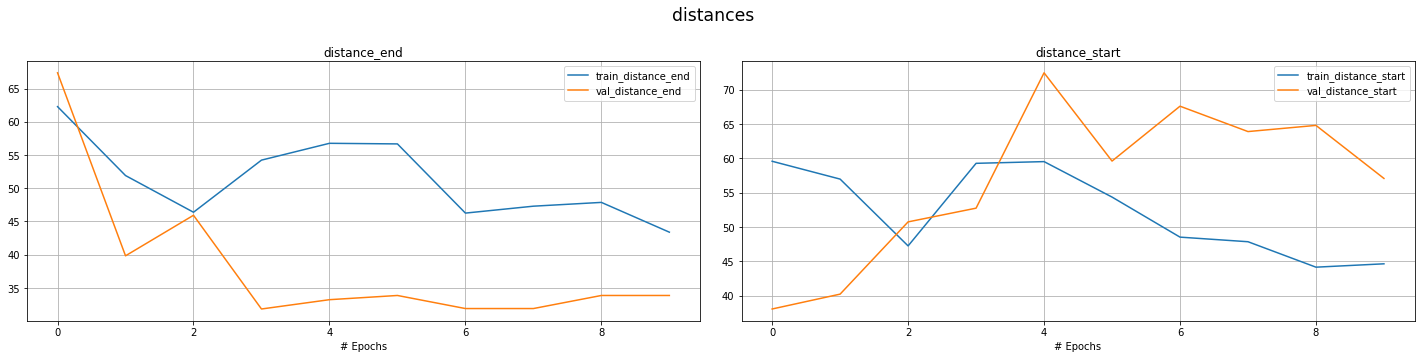

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline
 

def plot_history(history, title, save = True):    
    # this function is simply used to plot and save the image (and the dictionary) about the train and val loss and accuracy during the training
    
    
    fig1, axes = plt.subplots(nrows=1, ncols=1, figsize=(7.5, 5))
    plt.suptitle('loss', size='xx-large')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    axes.plot(history['loss'], label='train_loss')
    axes.plot(history['val_loss'], label='val_loss')
    axes.set_title('loss')
    axes.set(xlabel='# Epochs')
    axes.grid()
    axes.legend();

    fig2, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
    plt.suptitle('scores', size='xx-large')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    axes[0].plot(history['exact_score'], label='train_exact_score')
    axes[0].plot(history['val_exact_score'], label='val_exact_score')
    axes[0].set_title('exact_score')
    axes[0].set(xlabel='# Epochs')
    axes[0].grid()
    axes[0].legend();

    axes[1].plot(history['f1_score'], label='train_f1_score')
    axes[1].plot(history['val_f1_score'], label='val_f1_score')
    axes[1].set_title('f1_score')
    axes[1].set(xlabel='# Epochs')
    axes[1].grid()
    axes[1].legend();
    
    fig3, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
    plt.suptitle('distances', size='xx-large')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    axes[0].plot(history['distance_end'], label='train_distance_end')
    axes[0].plot(history['val_distance_end'], label='val_distance_end')
    axes[0].set_title('distance_end')
    axes[0].set(xlabel='# Epochs')
    axes[0].grid()
    axes[0].legend();

    axes[1].plot(history['distance_start'], label='train_distance_start')
    axes[1].plot(history['val_distance_start'], label='val_distance_start')
    axes[1].set_title('distance_start')
    axes[1].set(xlabel='# Epochs')
    axes[1].grid()
    axes[1].legend();
        
plot_history(history, "history_bidaf")

In [17]:
from utils.bidaf_loss import bidaf_loss

train_data = to_list_of_tuples((X_trainC, X_trainQ, Y_train))
val_data = to_list_of_tuples((X_valC, X_valQ, Y_val))

EP = 100
BS = 32

optimizer = torch.optim.Adam(model_bidaf.parameters(), lr=5e-3)
#optimizer = torch.optim.Adadelta(model_bidaf.parameters(), lr=0.5, rho=0.999, eps=1e-06, weight_decay=0) # slower in time and in loss
criterion = bidaf_loss

history = training_loop(model=model_bidaf,
                        train_data=train_data,
                        optimizer=optimizer,
                        epochs=EP,
                        batch_size=BS,
                        criterion=criterion,
                        train_tensor_maker=train_tensor_maker,
                        val_tensor_maker=val_tensor_maker,
                        val_data=val_data,
                        early_stopping=False,
                        patience = 15,
                        checkpoint_path='bidaf_baseline.pt')

----------------------------------------------------------------------------------------------------
Epoch 1/100


Start (p): 0, End (p): 0, Start (T): 44, End (T): 45
	Loss: 7.60800 - Distance start: 37 - Distance end: 37 [Time elapsed: 110.05 s]


Start (p): 24, End (p): 7, Start (T): 6, End (T): 7
	Validation loss: 7.11024 - Distance start: 35.00 - Distance end: 35.00 [Time elapsed: 11.67 s]
----------------------------------------------------------------------------------------------------
Epoch 2/100


Start (p): 121, End (p): 27, Start (T): 78, End (T): 81
	Loss: 6.94451 - Distance start: 36 - Distance end: 37 [Time elapsed: 115.41 s]


Start (p): 84, End (p): 85, Start (T): 164, End (T): 166
	Validation loss: 7.02693 - Distance start: 35.00 - Distance end: 36.00 [Time elapsed: 12.60 s]
----------------------------------------------------------------------------------------------------
Epoch 3/100


Start (p): 0, End (p): 1, Start (T): 153, End (T): 157
	Loss: 6.71470 - Distance start: 35 - Distance end: 36 [Time elapsed: 110.19 s]


Start (p): 32, End (p): 82, Start (T): 7, End (T): 7
	Validation loss: 6.84756 - Distance start: 34.00 - Distance end: 35.00 [Time elapsed: 11.37 s]
----------------------------------------------------------------------------------------------------
Epoch 4/100


Start (p): 3, End (p): 6, Start (T): 67, End (T): 68
	Loss: 6.57629 - Distance start: 36 - Distance end: 36 [Time elapsed: 106.70 s]


Start (p): 50, End (p): 12, Start (T): 6, End (T): 7
	Validation loss: 6.89861 - Distance start: 34.00 - Distance end: 35.00 [Time elapsed: 11.69 s]
----------------------------------------------------------------------------------------------------
Epoch 5/100


Start (p): 37, End (p): 64, Start (T): 21, End (T): 24
	Loss: 6.46257 - Distance start: 35 - Distance end: 36 [Time elapsed: 107.13 s]


Start (p): 162, End (p): 73, Start (T): 170, End (T): 174
	Validation loss: 6.78625 - Distance start: 33.00 - Distance end: 34.00 [Time elapsed: 11.55 s]
----------------------------------------------------------------------------------------------------
Epoch 6/100


Start (p): 103, End (p): 105, Start (T): 2, End (T): 3
	Loss: 6.36714 - Distance start: 35 - Distance end: 36 [Time elapsed: 106.21 s]


Start (p): 3, End (p): 27, Start (T): 85, End (T): 90
	Validation loss: 6.83648 - Distance start: 34.00 - Distance end: 37.00 [Time elapsed: 11.59 s]
----------------------------------------------------------------------------------------------------
Epoch 7/100


Start (p): 3, End (p): 4, Start (T): 94, End (T): 96
	Loss: 6.28323 - Distance start: 35 - Distance end: 35 [Time elapsed: 107.80 s]


Start (p): 16, End (p): 25, Start (T): 16, End (T): 16
	Validation loss: 6.86531 - Distance start: 34.00 - Distance end: 34.00 [Time elapsed: 11.64 s]
----------------------------------------------------------------------------------------------------
Epoch 8/100


Start (p): 59, End (p): 52, Start (T): 35, End (T): 37
	Loss: 6.29321 - Distance start: 35 - Distance end: 35 [Time elapsed: 106.35 s]


Start (p): 6, End (p): 6, Start (T): 19, End (T): 20
	Validation loss: 6.85963 - Distance start: 33.00 - Distance end: 35.00 [Time elapsed: 11.72 s]
----------------------------------------------------------------------------------------------------
Epoch 9/100


Start (p): 33, End (p): 40, Start (T): 75, End (T): 75
	Loss: 6.14563 - Distance start: 35 - Distance end: 35 [Time elapsed: 108.96 s]


Start (p): 8, End (p): 11, Start (T): 30, End (T): 32
	Validation loss: 6.91665 - Distance start: 35.00 - Distance end: 35.00 [Time elapsed: 11.74 s]
----------------------------------------------------------------------------------------------------
Epoch 10/100


Start (p): 107, End (p): 108, Start (T): 95, End (T): 96
	Loss: 6.02395 - Distance start: 34 - Distance end: 34 [Time elapsed: 109.16 s]


Start (p): 20, End (p): 20, Start (T): 20, End (T): 22
	Validation loss: 6.95041 - Distance start: 35.00 - Distance end: 36.00 [Time elapsed: 11.86 s]
----------------------------------------------------------------------------------------------------
Epoch 11/100


Start (p): 8, End (p): 14, Start (T): 16, End (T): 16
	Loss: 5.88436 - Distance start: 33 - Distance end: 34 [Time elapsed: 111.32 s]


Start (p): 0, End (p): 2, Start (T): 0, End (T): 2
	Validation loss: 6.89500 - Distance start: 35.00 - Distance end: 35.00 [Time elapsed: 11.80 s]
----------------------------------------------------------------------------------------------------
Epoch 12/100


Start (p): 15, End (p): 11, Start (T): 97, End (T): 98
	Loss: 5.77109 - Distance start: 32 - Distance end: 33 [Time elapsed: 95.95 s]


Start (p): 11, End (p): 13, Start (T): 35, End (T): 36
	Validation loss: 6.96675 - Distance start: 33.00 - Distance end: 34.00 [Time elapsed: 4.08 s]
----------------------------------------------------------------------------------------------------
Epoch 13/100


Start (p): 40, End (p): 67, Start (T): 92, End (T): 93
	Loss: 5.61458 - Distance start: 32 - Distance end: 32 [Time elapsed: 36.64 s]


Start (p): 20, End (p): 45, Start (T): 285, End (T): 286
	Validation loss: 6.87643 - Distance start: 34.00 - Distance end: 33.00 [Time elapsed: 4.27 s]
----------------------------------------------------------------------------------------------------
Epoch 14/100


Start (p): 74, End (p): 75, Start (T): 75, End (T): 75
	Loss: 5.39935 - Distance start: 31 - Distance end: 31 [Time elapsed: 36.71 s]


Start (p): 12, End (p): 30, Start (T): 0, End (T): 1
	Validation loss: 6.73237 - Distance start: 33.00 - Distance end: 32.00 [Time elapsed: 4.28 s]
----------------------------------------------------------------------------------------------------
Epoch 15/100


Start (p): 1, End (p): 11, Start (T): 37, End (T): 38
	Loss: 5.23829 - Distance start: 30 - Distance end: 30 [Time elapsed: 37.11 s]


Start (p): 44, End (p): 45, Start (T): 107, End (T): 108
	Validation loss: 6.73815 - Distance start: 34.00 - Distance end: 34.00 [Time elapsed: 4.29 s]
----------------------------------------------------------------------------------------------------
Epoch 16/100


Start (p): 160, End (p): 104, Start (T): 87, End (T): 90
	Loss: 5.12539 - Distance start: 30 - Distance end: 30 [Time elapsed: 36.71 s]


Start (p): 33, End (p): 9, Start (T): 7, End (T): 9
	Validation loss: 6.70006 - Distance start: 33.00 - Distance end: 34.00 [Time elapsed: 4.25 s]
----------------------------------------------------------------------------------------------------
Epoch 17/100


Start (p): 15, End (p): 22, Start (T): 15, End (T): 16
	Loss: 5.01007 - Distance start: 29 - Distance end: 30 [Time elapsed: 36.79 s]


Start (p): 0, End (p): 58, Start (T): 86, End (T): 87
	Validation loss: 6.82358 - Distance start: 34.00 - Distance end: 32.00 [Time elapsed: 4.24 s]
----------------------------------------------------------------------------------------------------
Epoch 18/100


Start (p): 4, End (p): 6, Start (T): 82, End (T): 86
	Loss: 4.91866 - Distance start: 29 - Distance end: 29 [Time elapsed: 36.88 s]


Start (p): 8, End (p): 142, Start (T): 222, End (T): 223
	Validation loss: 6.73958 - Distance start: 32.00 - Distance end: 32.00 [Time elapsed: 4.28 s]
----------------------------------------------------------------------------------------------------
Epoch 19/100


Start (p): 55, End (p): 61, Start (T): 55, End (T): 61
	Loss: 4.80497 - Distance start: 29 - Distance end: 29 [Time elapsed: 36.91 s]


Start (p): 14, End (p): 18, Start (T): 14, End (T): 18
	Validation loss: 6.80873 - Distance start: 33.00 - Distance end: 33.00 [Time elapsed: 4.27 s]
----------------------------------------------------------------------------------------------------
Epoch 20/100


Start (p): 0, End (p): 5, Start (T): 70, End (T): 76
	Loss: 4.75277 - Distance start: 28 - Distance end: 28 [Time elapsed: 36.68 s]


Start (p): 2, End (p): 2, Start (T): 43, End (T): 43
	Validation loss: 6.93565 - Distance start: 33.00 - Distance end: 33.00 [Time elapsed: 4.23 s]
----------------------------------------------------------------------------------------------------
Epoch 21/100


Start (p): 53, End (p): 34, Start (T): 34, End (T): 34
	Loss: 4.68482 - Distance start: 28 - Distance end: 28 [Time elapsed: 36.68 s]


Start (p): 0, End (p): 52, Start (T): 92, End (T): 95
	Validation loss: 6.78162 - Distance start: 33.00 - Distance end: 33.00 [Time elapsed: 4.26 s]
----------------------------------------------------------------------------------------------------
Epoch 22/100


Start (p): 0, End (p): 47, Start (T): 43, End (T): 47
	Loss: 4.59838 - Distance start: 27 - Distance end: 28 [Time elapsed: 36.59 s]


Start (p): 26, End (p): 83, Start (T): 115, End (T): 115
	Validation loss: 6.95624 - Distance start: 33.00 - Distance end: 32.00 [Time elapsed: 4.22 s]
----------------------------------------------------------------------------------------------------
Epoch 23/100


Start (p): 126, End (p): 117, Start (T): 39, End (T): 45
	Loss: 4.52437 - Distance start: 27 - Distance end: 27 [Time elapsed: 36.89 s]


Start (p): 75, End (p): 77, Start (T): 18, End (T): 21
	Validation loss: 7.03176 - Distance start: 33.00 - Distance end: 32.00 [Time elapsed: 4.30 s]
----------------------------------------------------------------------------------------------------
Epoch 24/100


Start (p): 6, End (p): 7, Start (T): 6, End (T): 7
	Loss: 4.46710 - Distance start: 27 - Distance end: 27 [Time elapsed: 36.60 s]


Start (p): 12, End (p): 15, Start (T): 20, End (T): 21
	Validation loss: 7.06623 - Distance start: 33.00 - Distance end: 33.00 [Time elapsed: 4.26 s]
----------------------------------------------------------------------------------------------------
Epoch 25/100


Start (p): 45, End (p): 46, Start (T): 45, End (T): 46
	Loss: 4.40651 - Distance start: 27 - Distance end: 27 [Time elapsed: 36.35 s]


Start (p): 1, End (p): 1, Start (T): 8, End (T): 9
	Validation loss: 7.12683 - Distance start: 32.00 - Distance end: 32.00 [Time elapsed: 4.22 s]
----------------------------------------------------------------------------------------------------
Epoch 26/100


Start (p): 115, End (p): 5, Start (T): 171, End (T): 174
	Loss: 4.33829 - Distance start: 26 - Distance end: 26 [Time elapsed: 36.58 s]


Start (p): 6, End (p): 47, Start (T): 72, End (T): 76
	Validation loss: 7.15982 - Distance start: 32.00 - Distance end: 31.00 [Time elapsed: 4.23 s]
----------------------------------------------------------------------------------------------------
Epoch 27/100


Start (p): 43, End (p): 37, Start (T): 128, End (T): 142
	Loss: 4.31186 - Distance start: 26 - Distance end: 26 [Time elapsed: 36.65 s]


Start (p): 3, End (p): 3, Start (T): 36, End (T): 37
	Validation loss: 7.39431 - Distance start: 32.00 - Distance end: 32.00 [Time elapsed: 4.25 s]
----------------------------------------------------------------------------------------------------
Epoch 28/100


Start (p): 69, End (p): 70, Start (T): 109, End (T): 111
	Loss: 4.24072 - Distance start: 26 - Distance end: 26 [Time elapsed: 36.63 s]


Start (p): 3, End (p): 1, Start (T): 18, End (T): 18
	Validation loss: 7.13809 - Distance start: 33.00 - Distance end: 33.00 [Time elapsed: 4.23 s]
----------------------------------------------------------------------------------------------------
Epoch 29/100


Start (p): 61, End (p): 30, Start (T): 61, End (T): 99
	Loss: 4.17142 - Distance start: 26 - Distance end: 26 [Time elapsed: 36.31 s]


Start (p): 66, End (p): 69, Start (T): 68, End (T): 69
	Validation loss: 7.30322 - Distance start: 32.00 - Distance end: 32.00 [Time elapsed: 4.26 s]
----------------------------------------------------------------------------------------------------
Epoch 30/100


Start (p): 51, End (p): 51, Start (T): 19, End (T): 20
	Loss: 4.10519 - Distance start: 25 - Distance end: 25 [Time elapsed: 36.86 s]


Start (p): 41, End (p): 42, Start (T): 3, End (T): 4
	Validation loss: 7.19459 - Distance start: 32.00 - Distance end: 32.00 [Time elapsed: 4.22 s]
----------------------------------------------------------------------------------------------------
Epoch 31/100


Start (p): 31, End (p): 32, Start (T): 0, End (T): 2
	Loss: 4.06801 - Distance start: 25 - Distance end: 25 [Time elapsed: 36.79 s]


Start (p): 29, End (p): 4, Start (T): 50, End (T): 50
	Validation loss: 7.43723 - Distance start: 31.00 - Distance end: 32.00 [Time elapsed: 4.17 s]
----------------------------------------------------------------------------------------------------
Epoch 32/100


Start (p): 16, End (p): 22, Start (T): 18, End (T): 19
	Loss: 4.02303 - Distance start: 24 - Distance end: 25 [Time elapsed: 36.64 s]


Start (p): 72, End (p): 122, Start (T): 40, End (T): 42
	Validation loss: 7.39556 - Distance start: 32.00 - Distance end: 31.00 [Time elapsed: 4.24 s]
----------------------------------------------------------------------------------------------------
Epoch 33/100


Start (p): 185, End (p): 186, Start (T): 23, End (T): 34
	Loss: 3.94810 - Distance start: 24 - Distance end: 24 [Time elapsed: 36.78 s]


Start (p): 26, End (p): 26, Start (T): 41, End (T): 42
	Validation loss: 7.73571 - Distance start: 32.00 - Distance end: 32.00 [Time elapsed: 4.18 s]
----------------------------------------------------------------------------------------------------
Epoch 34/100


Start (p): 1, End (p): 27, Start (T): 1, End (T): 2
	Loss: 3.89757 - Distance start: 24 - Distance end: 24 [Time elapsed: 36.58 s]


Start (p): 16, End (p): 1, Start (T): 16, End (T): 19
	Validation loss: 7.62496 - Distance start: 32.00 - Distance end: 32.00 [Time elapsed: 4.20 s]
----------------------------------------------------------------------------------------------------
Epoch 35/100


Start (p): 1, End (p): 20, Start (T): 1, End (T): 2
	Loss: 3.88929 - Distance start: 24 - Distance end: 24 [Time elapsed: 36.84 s]


Start (p): 40, End (p): 44, Start (T): 9, End (T): 12
	Validation loss: 7.62533 - Distance start: 31.00 - Distance end: 33.00 [Time elapsed: 4.24 s]
----------------------------------------------------------------------------------------------------
Epoch 36/100


Start (p): 37, End (p): 38, Start (T): 37, End (T): 38
	Loss: 3.86908 - Distance start: 24 - Distance end: 24 [Time elapsed: 36.65 s]


Start (p): 26, End (p): 27, Start (T): 113, End (T): 113
	Validation loss: 7.63650 - Distance start: 32.00 - Distance end: 32.00 [Time elapsed: 4.21 s]
----------------------------------------------------------------------------------------------------
Epoch 37/100


Start (p): 132, End (p): 120, Start (T): 40, End (T): 42
	Loss: 3.79643 - Distance start: 23 - Distance end: 23 [Time elapsed: 36.74 s]


Start (p): 29, End (p): 36, Start (T): 29, End (T): 31
	Validation loss: 7.68698 - Distance start: 32.00 - Distance end: 34.00 [Time elapsed: 4.25 s]
----------------------------------------------------------------------------------------------------
Epoch 38/100


Start (p): 85, End (p): 86, Start (T): 85, End (T): 86
	Loss: 3.72313 - Distance start: 23 - Distance end: 23 [Time elapsed: 36.38 s]


Start (p): 14, End (p): 15, Start (T): 111, End (T): 113
	Validation loss: 7.84459 - Distance start: 31.00 - Distance end: 33.00 [Time elapsed: 4.27 s]
----------------------------------------------------------------------------------------------------
Epoch 39/100


Start (p): 0, End (p): 0, Start (T): 0, End (T): 0
	Loss: 3.72567 - Distance start: 23 - Distance end: 23 [Time elapsed: 36.78 s]


Start (p): 101, End (p): 63, Start (T): 122, End (T): 123
	Validation loss: 7.78774 - Distance start: 32.00 - Distance end: 32.00 [Time elapsed: 4.27 s]
----------------------------------------------------------------------------------------------------
Epoch 40/100


Start (p): 7, End (p): 28, Start (T): 27, End (T): 28
	Loss: 3.62329 - Distance start: 22 - Distance end: 22 [Time elapsed: 36.49 s]


Start (p): 77, End (p): 35, Start (T): 11, End (T): 11
	Validation loss: 8.03576 - Distance start: 33.00 - Distance end: 33.00 [Time elapsed: 4.21 s]
----------------------------------------------------------------------------------------------------
Epoch 41/100


Start (p): 6, End (p): 12, Start (T): 6, End (T): 12
	Loss: 3.60884 - Distance start: 22 - Distance end: 22 [Time elapsed: 36.82 s]


Start (p): 87, End (p): 25, Start (T): 88, End (T): 90
	Validation loss: 8.10044 - Distance start: 32.00 - Distance end: 33.00 [Time elapsed: 4.23 s]
----------------------------------------------------------------------------------------------------
Epoch 42/100


Start (p): 16, End (p): 5, Start (T): 16, End (T): 18
	Loss: 3.57909 - Distance start: 22 - Distance end: 23 [Time elapsed: 36.64 s]


Start (p): 112, End (p): 116, Start (T): 68, End (T): 69
	Validation loss: 8.32521 - Distance start: 31.00 - Distance end: 32.00 [Time elapsed: 4.28 s]
----------------------------------------------------------------------------------------------------
Epoch 43/100


Start (p): 6, End (p): 85, Start (T): 30, End (T): 31
	Loss: 3.55529 - Distance start: 22 - Distance end: 22 [Time elapsed: 36.53 s]


Start (p): 69, End (p): 70, Start (T): 75, End (T): 77
	Validation loss: 7.98856 - Distance start: 32.00 - Distance end: 32.00 [Time elapsed: 4.23 s]
----------------------------------------------------------------------------------------------------
Epoch 44/100


Start (p): 77, End (p): 148, Start (T): 54, End (T): 55
	Loss: 3.51295 - Distance start: 22 - Distance end: 22 [Time elapsed: 36.37 s]


Start (p): 9, End (p): 7, Start (T): 47, End (T): 47
	Validation loss: 8.12136 - Distance start: 32.00 - Distance end: 32.00 [Time elapsed: 4.22 s]
----------------------------------------------------------------------------------------------------
Epoch 45/100


Start (p): 72, End (p): 66, Start (T): 69, End (T): 70
	Loss: 3.47308 - Distance start: 21 - Distance end: 22 [Time elapsed: 36.63 s]


Start (p): 0, End (p): 2, Start (T): 65, End (T): 66
	Validation loss: 8.18003 - Distance start: 32.00 - Distance end: 33.00 [Time elapsed: 4.21 s]
----------------------------------------------------------------------------------------------------
Epoch 46/100


Start (p): 31, End (p): 6, Start (T): 5, End (T): 6
	Loss: 3.45379 - Distance start: 21 - Distance end: 22 [Time elapsed: 36.60 s]


Start (p): 93, End (p): 95, Start (T): 93, End (T): 95
	Validation loss: inf - Distance start: 31.00 - Distance end: 32.00 [Time elapsed: 4.23 s]
----------------------------------------------------------------------------------------------------
Epoch 47/100


Start (p): 95, End (p): 130, Start (T): 129, End (T): 130
	Loss: 3.42979 - Distance start: 21 - Distance end: 21 [Time elapsed: 36.73 s]


Start (p): 43, End (p): 43, Start (T): 43, End (T): 43
	Validation loss: 8.32703 - Distance start: 33.00 - Distance end: 32.00 [Time elapsed: 4.19 s]
----------------------------------------------------------------------------------------------------
Epoch 48/100


Start (p): 88, End (p): 90, Start (T): 88, End (T): 90
	Loss: 3.35345 - Distance start: 21 - Distance end: 21 [Time elapsed: 36.50 s]


Start (p): 43, End (p): 2, Start (T): 7, End (T): 8
	Validation loss: 8.33488 - Distance start: 31.00 - Distance end: 31.00 [Time elapsed: 4.22 s]
----------------------------------------------------------------------------------------------------
Epoch 49/100


Start (p): 0, End (p): 1, Start (T): 0, End (T): 1
	Loss: 3.35723 - Distance start: 21 - Distance end: 21 [Time elapsed: 36.75 s]


Start (p): 37, End (p): 37, Start (T): 34, End (T): 35
	Validation loss: 8.49029 - Distance start: 32.00 - Distance end: 32.00 [Time elapsed: 4.35 s]
----------------------------------------------------------------------------------------------------
Epoch 50/100


Start (p): 18, End (p): 33, Start (T): 32, End (T): 34
	Loss: 3.30720 - Distance start: 20 - Distance end: 20 [Time elapsed: 36.82 s]


Start (p): 87, End (p): 5, Start (T): 45, End (T): 47
	Validation loss: 8.44391 - Distance start: 32.00 - Distance end: 32.00 [Time elapsed: 4.30 s]
----------------------------------------------------------------------------------------------------
Epoch 51/100


Start (p): 76, End (p): 78, Start (T): 76, End (T): 78
	Loss: 3.24740 - Distance start: 20 - Distance end: 20 [Time elapsed: 36.81 s]


Start (p): 6, End (p): 7, Start (T): 122, End (T): 123
	Validation loss: 8.51226 - Distance start: 32.00 - Distance end: 31.00 [Time elapsed: 4.24 s]
----------------------------------------------------------------------------------------------------
Epoch 52/100


Start (p): 69, End (p): 28, Start (T): 69, End (T): 70
	Loss: 3.25597 - Distance start: 20 - Distance end: 20 [Time elapsed: 36.67 s]


Start (p): 6, End (p): 6, Start (T): 13, End (T): 13
	Validation loss: 8.76695 - Distance start: 31.00 - Distance end: 32.00 [Time elapsed: 4.19 s]
----------------------------------------------------------------------------------------------------
Epoch 53/100


Start (p): 25, End (p): 25, Start (T): 22, End (T): 25
	Loss: 3.24561 - Distance start: 20 - Distance end: 20 [Time elapsed: 38.87 s]


Start (p): 61, End (p): 61, Start (T): 104, End (T): 105
	Validation loss: 8.74259 - Distance start: 32.00 - Distance end: 32.00 [Time elapsed: 4.85 s]
----------------------------------------------------------------------------------------------------
Epoch 54/100


Start (p): 27, End (p): 27, Start (T): 27, End (T): 27
	Loss: 3.17911 - Distance start: 20 - Distance end: 20 [Time elapsed: 38.38 s]


Start (p): 61, End (p): 16, Start (T): 37, End (T): 39
	Validation loss: 8.46342 - Distance start: 32.00 - Distance end: 32.00 [Time elapsed: 4.55 s]
----------------------------------------------------------------------------------------------------
Epoch 55/100


Start (p): 32, End (p): 11, Start (T): 9, End (T): 11
	Loss: 3.20915 - Distance start: 20 - Distance end: 20 [Time elapsed: 37.57 s]


Start (p): 53, End (p): 53, Start (T): 34, End (T): 34
	Validation loss: 8.61791 - Distance start: 31.00 - Distance end: 32.00 [Time elapsed: 4.25 s]
----------------------------------------------------------------------------------------------------
Epoch 56/100


Start (p): 184, End (p): 245, Start (T): 105, End (T): 106
	Loss: 3.17890 - Distance start: 19 - Distance end: 20 [Time elapsed: 36.76 s]


Start (p): 42, End (p): 48, Start (T): 47, End (T): 48
	Validation loss: 8.76885 - Distance start: 32.00 - Distance end: 32.00 [Time elapsed: 4.23 s]
----------------------------------------------------------------------------------------------------
Epoch 57/100


Start (p): 54, End (p): 54, Start (T): 54, End (T): 54
	Loss: 3.14039 - Distance start: 19 - Distance end: 19 [Time elapsed: 36.74 s]


Start (p): 74, End (p): 74, Start (T): 72, End (T): 76
	Validation loss: inf - Distance start: 32.00 - Distance end: 32.00 [Time elapsed: 4.22 s]
----------------------------------------------------------------------------------------------------
Epoch 58/100


Start (p): 21, End (p): 21, Start (T): 17, End (T): 17
	Loss: 3.32867 - Distance start: 20 - Distance end: 20 [Time elapsed: 37.43 s]


Start (p): 11, End (p): 11, Start (T): 60, End (T): 67
	Validation loss: 8.30181 - Distance start: 32.00 - Distance end: 33.00 [Time elapsed: 4.36 s]
----------------------------------------------------------------------------------------------------
Epoch 59/100


Start (p): 69, End (p): 43, Start (T): 39, End (T): 43
	Loss: 4.70703 - Distance start: 26 - Distance end: 26 [Time elapsed: 37.79 s]


Start (p): 13, End (p): 35, Start (T): 31, End (T): 32
	Validation loss: 7.70668 - Distance start: 32.00 - Distance end: 32.00 [Time elapsed: 4.25 s]
----------------------------------------------------------------------------------------------------
Epoch 60/100


Start (p): 7, End (p): 46, Start (T): 36, End (T): 38
	Loss: 3.73403 - Distance start: 22 - Distance end: 22 [Time elapsed: 36.62 s]


Start (p): 44, End (p): 43, Start (T): 68, End (T): 69
	Validation loss: 8.04334 - Distance start: 32.00 - Distance end: 32.00 [Time elapsed: 4.22 s]
----------------------------------------------------------------------------------------------------
Epoch 61/100


Start (p): 57, End (p): 57, Start (T): 57, End (T): 57
	Loss: 3.33248 - Distance start: 20 - Distance end: 20 [Time elapsed: 36.76 s]


Start (p): 38, End (p): 70, Start (T): 1, End (T): 3
	Validation loss: 8.65308 - Distance start: 32.00 - Distance end: 33.00 [Time elapsed: 4.26 s]
----------------------------------------------------------------------------------------------------
Epoch 62/100


Start (p): 40, End (p): 220, Start (T): 218, End (T): 220
	Loss: 3.24826 - Distance start: 20 - Distance end: 20 [Time elapsed: 36.71 s]


Start (p): 162, End (p): 156, Start (T): 47, End (T): 52
	Validation loss: 8.33788 - Distance start: 32.00 - Distance end: 33.00 [Time elapsed: 4.25 s]
----------------------------------------------------------------------------------------------------
Epoch 63/100


Start (p): 3, End (p): 3, Start (T): 3, End (T): 3
	Loss: 3.17670 - Distance start: 19 - Distance end: 19 [Time elapsed: 37.09 s]


Start (p): 60, End (p): 61, Start (T): 61, End (T): 61
	Validation loss: 8.58205 - Distance start: 32.00 - Distance end: 32.00 [Time elapsed: 4.24 s]
----------------------------------------------------------------------------------------------------
Epoch 64/100


Start (p): 64, End (p): 64, Start (T): 57, End (T): 64
	Loss: 3.13769 - Distance start: 19 - Distance end: 19 [Time elapsed: 36.72 s]


Start (p): 21, End (p): 45, Start (T): 46, End (T): 48
	Validation loss: 8.97741 - Distance start: 32.00 - Distance end: 32.00 [Time elapsed: 4.23 s]
----------------------------------------------------------------------------------------------------
Epoch 65/100


Start (p): 53, End (p): 33, Start (T): 53, End (T): 54
	Loss: 3.03956 - Distance start: 18 - Distance end: 18 [Time elapsed: 36.65 s]


Start (p): 7, End (p): 90, Start (T): 50, End (T): 53
	Validation loss: 8.77019 - Distance start: 32.00 - Distance end: 31.00 [Time elapsed: 4.25 s]
----------------------------------------------------------------------------------------------------
Epoch 66/100


Start (p): 27, End (p): 94, Start (T): 150, End (T): 159
	Loss: 3.01853 - Distance start: 18 - Distance end: 19 [Time elapsed: 36.85 s]


Start (p): 68, End (p): 104, Start (T): 35, End (T): 36
	Validation loss: 9.14086 - Distance start: 31.00 - Distance end: 33.00 [Time elapsed: 4.24 s]
----------------------------------------------------------------------------------------------------
Epoch 67/100


Start (p): 12, End (p): 10, Start (T): 8, End (T): 10
	Loss: 3.01169 - Distance start: 18 - Distance end: 18 [Time elapsed: 36.64 s]


Start (p): 9, End (p): 9, Start (T): 8, End (T): 11
	Validation loss: 9.15225 - Distance start: 32.00 - Distance end: 33.00 [Time elapsed: 4.27 s]
----------------------------------------------------------------------------------------------------
Epoch 68/100


Start (p): 76, End (p): 76, Start (T): 76, End (T): 76
	Loss: 3.02278 - Distance start: 18 - Distance end: 18 [Time elapsed: 36.71 s]


Start (p): 69, End (p): 69, Start (T): 69, End (T): 69
	Validation loss: 9.02031 - Distance start: 31.00 - Distance end: 32.00 [Time elapsed: 4.20 s]
----------------------------------------------------------------------------------------------------
Epoch 69/100


Start (p): 17, End (p): 17, Start (T): 17, End (T): 17
	Loss: 7.55044 - Distance start: 35 - Distance end: 36 [Time elapsed: 37.00 s]


Start (p): 7, End (p): 7, Start (T): 62, End (T): 62
	Validation loss: 7.90555 - Distance start: 34.00 - Distance end: 38.00 [Time elapsed: 4.21 s]
----------------------------------------------------------------------------------------------------
Epoch 70/100


Start (p): 11, End (p): 83, Start (T): 86, End (T): 86
	Loss: 7.65933 - Distance start: 36 - Distance end: 38 [Time elapsed: 36.74 s]


Start (p): 16, End (p): 9, Start (T): 106, End (T): 108
	Validation loss: 7.71412 - Distance start: 35.00 - Distance end: 37.00 [Time elapsed: 4.22 s]
----------------------------------------------------------------------------------------------------
Epoch 71/100


Start (p): 22, End (p): 23, Start (T): 27, End (T): 27
	Loss: 7.46418 - Distance start: 36 - Distance end: 38 [Time elapsed: 36.49 s]


Start (p): 0, End (p): 27, Start (T): 40, End (T): 40
	Validation loss: 7.59030 - Distance start: 35.00 - Distance end: 36.00 [Time elapsed: 4.30 s]
----------------------------------------------------------------------------------------------------
Epoch 72/100


Start (p): 71, End (p): 33, Start (T): 32, End (T): 33
	Loss: 7.40337 - Distance start: 36 - Distance end: 38 [Time elapsed: 36.77 s]


Start (p): 50, End (p): 29, Start (T): 7, End (T): 9
	Validation loss: 7.56536 - Distance start: 35.00 - Distance end: 36.00 [Time elapsed: 4.20 s]
----------------------------------------------------------------------------------------------------
Epoch 73/100


Start (p): 0, End (p): 46, Start (T): 105, End (T): 107
	Loss: 7.48789 - Distance start: 37 - Distance end: 38 [Time elapsed: 36.36 s]


Start (p): 5, End (p): 6, Start (T): 31, End (T): 31
	Validation loss: 7.87731 - Distance start: 34.00 - Distance end: 36.00 [Time elapsed: 4.28 s]
----------------------------------------------------------------------------------------------------
Epoch 74/100


Start (p): 15, End (p): 20, Start (T): 162, End (T): 166
	Loss: 7.67780 - Distance start: 37 - Distance end: 38 [Time elapsed: 36.67 s]


Start (p): 11, End (p): 2, Start (T): 11, End (T): 13
	Validation loss: 7.62327 - Distance start: 34.00 - Distance end: 35.00 [Time elapsed: 4.25 s]
----------------------------------------------------------------------------------------------------
Epoch 75/100


Start (p): 1, End (p): 4, Start (T): 1, End (T): 2
	Loss: 7.53387 - Distance start: 36 - Distance end: 37 [Time elapsed: 36.75 s]


Start (p): 8, End (p): 24, Start (T): 44, End (T): 47
	Validation loss: 7.62726 - Distance start: 35.00 - Distance end: 36.00 [Time elapsed: 4.22 s]
----------------------------------------------------------------------------------------------------
Epoch 76/100


Start (p): 10, End (p): 10, Start (T): 69, End (T): 69
	Loss: 7.44613 - Distance start: 36 - Distance end: 37 [Time elapsed: 36.49 s]


Start (p): 0, End (p): 47, Start (T): 99, End (T): 104
	Validation loss: 7.56530 - Distance start: 33.00 - Distance end: 35.00 [Time elapsed: 4.28 s]
----------------------------------------------------------------------------------------------------
Epoch 77/100


Start (p): 20, End (p): 20, Start (T): 19, End (T): 22
	Loss: 7.37393 - Distance start: 36 - Distance end: 37 [Time elapsed: 36.69 s]


Start (p): 12, End (p): 12, Start (T): 12, End (T): 12
	Validation loss: 7.49667 - Distance start: 34.00 - Distance end: 35.00 [Time elapsed: 4.22 s]
----------------------------------------------------------------------------------------------------
Epoch 78/100


Start (p): 64, End (p): 64, Start (T): 82, End (T): 86
	Loss: 7.31772 - Distance start: 36 - Distance end: 36 [Time elapsed: 36.82 s]


Start (p): 32, End (p): 18, Start (T): 28, End (T): 29
	Validation loss: 7.45505 - Distance start: 34.00 - Distance end: 36.00 [Time elapsed: 4.25 s]
----------------------------------------------------------------------------------------------------
Epoch 79/100


Start (p): 5, End (p): 9, Start (T): 55, End (T): 56
	Loss: 7.27940 - Distance start: 36 - Distance end: 36 [Time elapsed: 38.12 s]


Start (p): 14, End (p): 14, Start (T): 12, End (T): 14
	Validation loss: 7.46271 - Distance start: 34.00 - Distance end: 36.00 [Time elapsed: 4.66 s]
----------------------------------------------------------------------------------------------------
Epoch 80/100


Start (p): 72, End (p): 128, Start (T): 36, End (T): 41
	Loss: 7.21995 - Distance start: 35 - Distance end: 36 [Time elapsed: 37.99 s]


Start (p): 19, End (p): 63, Start (T): 7, End (T): 9
	Validation loss: 7.49704 - Distance start: 34.00 - Distance end: 36.00 [Time elapsed: 4.32 s]
----------------------------------------------------------------------------------------------------
Epoch 81/100


Start (p): 21, End (p): 64, Start (T): 77, End (T): 78
	Loss: 7.20448 - Distance start: 36 - Distance end: 36 [Time elapsed: 36.75 s]


Start (p): 50, End (p): 51, Start (T): 1, End (T): 3
	Validation loss: 7.41811 - Distance start: 33.00 - Distance end: 35.00 [Time elapsed: 4.34 s]
----------------------------------------------------------------------------------------------------
Epoch 82/100


Start (p): 16, End (p): 12, Start (T): 109, End (T): 111
	Loss: 7.16383 - Distance start: 36 - Distance end: 36 [Time elapsed: 36.59 s]


Start (p): 11, End (p): 11, Start (T): 20, End (T): 20
	Validation loss: 7.42788 - Distance start: 33.00 - Distance end: 35.00 [Time elapsed: 4.22 s]
----------------------------------------------------------------------------------------------------
Epoch 83/100


Start (p): 6, End (p): 24, Start (T): 1, End (T): 5
	Loss: 7.12607 - Distance start: 36 - Distance end: 36 [Time elapsed: 36.71 s]


Start (p): 7, End (p): 24, Start (T): 21, End (T): 24
	Validation loss: 7.40336 - Distance start: 34.00 - Distance end: 34.00 [Time elapsed: 4.21 s]
----------------------------------------------------------------------------------------------------
Epoch 84/100


Start (p): 7, End (p): 8, Start (T): 7, End (T): 8
	Loss: 7.09111 - Distance start: 36 - Distance end: 35 [Time elapsed: 36.55 s]


Start (p): 84, End (p): 85, Start (T): 84, End (T): 88
	Validation loss: 7.42097 - Distance start: 34.00 - Distance end: 35.00 [Time elapsed: 4.24 s]
----------------------------------------------------------------------------------------------------
Epoch 85/100


Start (p): 87, End (p): 72, Start (T): 18, End (T): 23
	Loss: 7.07063 - Distance start: 35 - Distance end: 35 [Time elapsed: 36.69 s]


Start (p): 56, End (p): 12, Start (T): 15, End (T): 32
	Validation loss: 7.40648 - Distance start: 34.00 - Distance end: 37.00 [Time elapsed: 4.17 s]
----------------------------------------------------------------------------------------------------
Epoch 86/100


Start (p): 29, End (p): 19, Start (T): 159, End (T): 164
	Loss: 7.05489 - Distance start: 35 - Distance end: 35 [Time elapsed: 36.98 s]


Start (p): 43, End (p): 46, Start (T): 19, End (T): 20
	Validation loss: 7.46133 - Distance start: 34.00 - Distance end: 35.00 [Time elapsed: 4.65 s]
----------------------------------------------------------------------------------------------------
Epoch 87/100


Start (p): 26, End (p): 30, Start (T): 0, End (T): 1
	Loss: 7.02478 - Distance start: 35 - Distance end: 35 [Time elapsed: 37.41 s]


Start (p): 4, End (p): 4, Start (T): 47, End (T): 48
	Validation loss: 7.48861 - Distance start: 34.00 - Distance end: 35.00 [Time elapsed: 4.30 s]
----------------------------------------------------------------------------------------------------
Epoch 88/100


Start (p): 42, End (p): 45, Start (T): 6, End (T): 6
	Loss: 7.01786 - Distance start: 35 - Distance end: 36 [Time elapsed: 36.86 s]


Start (p): 39, End (p): 80, Start (T): 2, End (T): 2
	Validation loss: 7.39142 - Distance start: 33.00 - Distance end: 36.00 [Time elapsed: 4.33 s]
----------------------------------------------------------------------------------------------------
Epoch 89/100


Start (p): 27, End (p): 84, Start (T): 5, End (T): 6
	Loss: 6.97911 - Distance start: 35 - Distance end: 35 [Time elapsed: 37.01 s]


Start (p): 31, End (p): 32, Start (T): 203, End (T): 205
	Validation loss: 7.41336 - Distance start: 33.00 - Distance end: 35.00 [Time elapsed: 4.24 s]
----------------------------------------------------------------------------------------------------
Epoch 90/100


Start (p): 79, End (p): 112, Start (T): 13, End (T): 14
	Loss: 6.94992 - Distance start: 35 - Distance end: 35 [Time elapsed: 36.52 s]


Start (p): 5, End (p): 10, Start (T): 38, End (T): 40
	Validation loss: 7.42361 - Distance start: 35.00 - Distance end: 35.00 [Time elapsed: 4.28 s]
----------------------------------------------------------------------------------------------------
Epoch 91/100


Start (p): 4, End (p): 19, Start (T): 19, End (T): 19
	Loss: 6.90870 - Distance start: 35 - Distance end: 36 [Time elapsed: 36.67 s]


Start (p): 17, End (p): 18, Start (T): 75, End (T): 78
	Validation loss: 7.41830 - Distance start: 33.00 - Distance end: 34.00 [Time elapsed: 4.22 s]
----------------------------------------------------------------------------------------------------
Epoch 92/100


Start (p): 77, End (p): 10, Start (T): 77, End (T): 79
	Loss: 6.88626 - Distance start: 35 - Distance end: 35 [Time elapsed: 36.58 s]


Start (p): 39, End (p): 10, Start (T): 61, End (T): 61
	Validation loss: 7.39293 - Distance start: 33.00 - Distance end: 34.00 [Time elapsed: 4.26 s]
----------------------------------------------------------------------------------------------------
Epoch 93/100


Start (p): 1, End (p): 3, Start (T): 0, End (T): 3
	Loss: 6.86206 - Distance start: 35 - Distance end: 36 [Time elapsed: 36.51 s]


Start (p): 64, End (p): 93, Start (T): 108, End (T): 108
	Validation loss: 7.42011 - Distance start: 34.00 - Distance end: 35.00 [Time elapsed: 4.22 s]
----------------------------------------------------------------------------------------------------
Epoch 94/100


Start (p): 22, End (p): 104, Start (T): 22, End (T): 23
	Loss: 6.84489 - Distance start: 35 - Distance end: 35 [Time elapsed: 36.48 s]


Start (p): 37, End (p): 22, Start (T): 37, End (T): 41
	Validation loss: 7.44518 - Distance start: 34.00 - Distance end: 35.00 [Time elapsed: 4.24 s]
----------------------------------------------------------------------------------------------------
Epoch 95/100


Start (p): 33, End (p): 34, Start (T): 156, End (T): 157
	Loss: 6.81892 - Distance start: 35 - Distance end: 36 [Time elapsed: 36.93 s]


Start (p): 56, End (p): 11, Start (T): 108, End (T): 110
	Validation loss: 7.47181 - Distance start: 35.00 - Distance end: 35.00 [Time elapsed: 4.21 s]
----------------------------------------------------------------------------------------------------
Epoch 96/100


Start (p): 64, End (p): 55, Start (T): 5, End (T): 10
	Loss: 6.80795 - Distance start: 35 - Distance end: 35 [Time elapsed: 36.48 s]


Start (p): 19, End (p): 79, Start (T): 4, End (T): 9
	Validation loss: 7.38113 - Distance start: 33.00 - Distance end: 35.00 [Time elapsed: 4.25 s]
----------------------------------------------------------------------------------------------------
Epoch 97/100


Start (p): 19, End (p): 13, Start (T): 12, End (T): 13
	Loss: 6.79002 - Distance start: 35 - Distance end: 35 [Time elapsed: 36.66 s]


Start (p): 10, End (p): 10, Start (T): 11, End (T): 11
	Validation loss: 7.48797 - Distance start: 34.00 - Distance end: 34.00 [Time elapsed: 4.24 s]
----------------------------------------------------------------------------------------------------
Epoch 98/100


Start (p): 28, End (p): 29, Start (T): 89, End (T): 89
	Loss: 6.75511 - Distance start: 35 - Distance end: 35 [Time elapsed: 36.52 s]


Start (p): 26, End (p): 19, Start (T): 0, End (T): 0
	Validation loss: 7.44851 - Distance start: 34.00 - Distance end: 35.00 [Time elapsed: 4.32 s]
----------------------------------------------------------------------------------------------------
Epoch 99/100


Start (p): 48, End (p): 49, Start (T): 21, End (T): 22
	Loss: 6.73548 - Distance start: 35 - Distance end: 35 [Time elapsed: 36.48 s]


Start (p): 24, End (p): 38, Start (T): 57, End (T): 61
	Validation loss: 7.37890 - Distance start: 34.00 - Distance end: 34.00 [Time elapsed: 4.24 s]
----------------------------------------------------------------------------------------------------
Epoch 100/100


Start (p): 158, End (p): 3, Start (T): 72, End (T): 77
	Loss: 6.72358 - Distance start: 35 - Distance end: 35 [Time elapsed: 36.65 s]


Start (p): 8, End (p): 63, Start (T): 60, End (T): 63
	Validation loss: 7.46228 - Distance start: 34.00 - Distance end: 34.00 [Time elapsed: 4.22 s]


# trying the constraint:

In [53]:
from model.bidaf import BiDAF
from model.char_embedder import CharEmbedder
from model.word_embedder import WordEmbedder
from model.tensor_maker import TensorMaker

char_embedder = CharEmbedder(init_emb = torch.FloatTensor(char_emb_mtx),
                             out_char_emb_dim = emb_dim,
                             hidden_dim = 64,
                             input_channels = 1,
                             output_channels = 100,
                             kernel_height = 5,
                             trainable = False)

train_word_embedder = WordEmbedder(init_emb = torch.FloatTensor(train_emb_mtx))
val_word_embedder = WordEmbedder(init_emb = torch.FloatTensor(val_emb_mtx))

model_bidaf = BiDAF(char_embedder, train_word_embedder, val_word_embedder, use_constraint = True).to(DEVICE)

train_tensor_maker = TensorMaker(train_w2i, c2i, device=DEVICE)
val_tensor_maker = TensorMaker(val_w2i, c2i, device=DEVICE)

In [54]:
from utils.bidaf_loss import bidaf_loss

train_data = to_list_of_tuples((X_trainC, X_trainQ, Y_train))
val_data = to_list_of_tuples((X_valC, X_valQ, Y_val))

EP = 100
BS = 32

optimizer = torch.optim.Adam(model_bidaf.parameters(), lr=5e-3)
#optimizer = torch.optim.Adadelta(model_bidaf.parameters(), lr=0.5, rho=0.999, eps=1e-06, weight_decay=0) # slower in time and in loss
criterion = bidaf_loss

history = training_loop(model=model_bidaf,
                        train_data=train_data,
                        optimizer=optimizer,
                        epochs=EP,
                        batch_size=BS,
                        criterion=criterion,
                        train_tensor_maker=train_tensor_maker,
                        val_tensor_maker=val_tensor_maker,
                        val_data=val_data,
                        early_stopping=False,
                        patience = 15,
                        checkpoint_path='bidaf_baseline.pt')

----------------------------------------------------------------------------------------------------
Epoch 1/100


Start (p): 63, End (p): 12, Start (T): 44, End (T): 45
	Loss: 7.42227 - Distance start: 37 - Distance end: 37 [Time elapsed: 38.46 s]


Start (p): 24, End (p): 7, Start (T): 6, End (T): 7
	Validation loss: 6.91218 - Distance start: 35.00 - Distance end: 34.00 [Time elapsed: 4.29 s]
----------------------------------------------------------------------------------------------------
Epoch 2/100


Start (p): 69, End (p): 48, Start (T): 78, End (T): 81
	Loss: 6.51461 - Distance start: 35 - Distance end: 35 [Time elapsed: 37.54 s]


Start (p): 8, End (p): 8, Start (T): 164, End (T): 166
	Validation loss: 6.37157 - Distance start: 33.00 - Distance end: 34.00 [Time elapsed: 4.31 s]
----------------------------------------------------------------------------------------------------
Epoch 3/100


Start (p): 0, End (p): 157, Start (T): 153, End (T): 157
	Loss: 6.01479 - Distance start: 32 - Distance end: 33 [Time elapsed: 39.34 s]


Start (p): 80, End (p): 74, Start (T): 7, End (T): 7
	Validation loss: 6.10884 - Distance start: 32.00 - Distance end: 32.00 [Time elapsed: 4.32 s]
----------------------------------------------------------------------------------------------------
Epoch 4/100


Start (p): 37, End (p): 0, Start (T): 67, End (T): 68
	Loss: 5.73731 - Distance start: 32 - Distance end: 32 [Time elapsed: 39.90 s]


Start (p): 50, End (p): 7, Start (T): 6, End (T): 7
	Validation loss: 6.02686 - Distance start: 31.00 - Distance end: 31.00 [Time elapsed: 4.40 s]
----------------------------------------------------------------------------------------------------
Epoch 5/100


Start (p): 11, End (p): 46, Start (T): 21, End (T): 24
	Loss: 5.51322 - Distance start: 31 - Distance end: 31 [Time elapsed: 38.11 s]


Start (p): 162, End (p): 73, Start (T): 170, End (T): 174
	Validation loss: 5.94240 - Distance start: 31.00 - Distance end: 30.00 [Time elapsed: 4.40 s]
----------------------------------------------------------------------------------------------------
Epoch 6/100


Start (p): 58, End (p): 63, Start (T): 2, End (T): 3
	Loss: 5.32735 - Distance start: 30 - Distance end: 30 [Time elapsed: 38.83 s]


Start (p): 101, End (p): 103, Start (T): 85, End (T): 90
	Validation loss: 5.94092 - Distance start: 31.00 - Distance end: 31.00 [Time elapsed: 4.26 s]
----------------------------------------------------------------------------------------------------
Epoch 7/100


Start (p): 94, End (p): 17, Start (T): 94, End (T): 96
	Loss: 5.18314 - Distance start: 29 - Distance end: 30 [Time elapsed: 37.49 s]


Start (p): 67, End (p): 67, Start (T): 16, End (T): 16
	Validation loss: 5.98059 - Distance start: 31.00 - Distance end: 32.00 [Time elapsed: 4.68 s]
----------------------------------------------------------------------------------------------------
Epoch 8/100


Start (p): 15, End (p): 52, Start (T): 35, End (T): 37
	Loss: 5.05100 - Distance start: 29 - Distance end: 29 [Time elapsed: 37.86 s]


Start (p): 6, End (p): 6, Start (T): 19, End (T): 20
	Validation loss: 5.91313 - Distance start: 31.00 - Distance end: 30.00 [Time elapsed: 4.27 s]
----------------------------------------------------------------------------------------------------
Epoch 9/100


Start (p): 33, End (p): 133, Start (T): 75, End (T): 75
	Loss: 4.92137 - Distance start: 28 - Distance end: 28 [Time elapsed: 39.04 s]


Start (p): 22, End (p): 11, Start (T): 30, End (T): 32
	Validation loss: 5.98115 - Distance start: 31.00 - Distance end: 30.00 [Time elapsed: 4.42 s]
----------------------------------------------------------------------------------------------------
Epoch 10/100


Start (p): 62, End (p): 67, Start (T): 95, End (T): 96
	Loss: 4.81633 - Distance start: 27 - Distance end: 28 [Time elapsed: 37.58 s]


Start (p): 20, End (p): 20, Start (T): 20, End (T): 22
	Validation loss: 6.10372 - Distance start: 30.00 - Distance end: 31.00 [Time elapsed: 5.27 s]
----------------------------------------------------------------------------------------------------
Epoch 11/100


Start (p): 8, End (p): 9, Start (T): 16, End (T): 16
	Loss: 4.72776 - Distance start: 27 - Distance end: 27 [Time elapsed: 38.55 s]


Start (p): 0, End (p): 2, Start (T): 0, End (T): 2
	Validation loss: 6.05534 - Distance start: 30.00 - Distance end: 31.00 [Time elapsed: 4.23 s]
----------------------------------------------------------------------------------------------------
Epoch 12/100


Start (p): 197, End (p): 11, Start (T): 97, End (T): 98
	Loss: 4.58720 - Distance start: 26 - Distance end: 26 [Time elapsed: 38.27 s]


Start (p): 39, End (p): 39, Start (T): 35, End (T): 36
	Validation loss: 6.21304 - Distance start: 30.00 - Distance end: 31.00 [Time elapsed: 4.34 s]
----------------------------------------------------------------------------------------------------
Epoch 13/100


Start (p): 92, End (p): 93, Start (T): 92, End (T): 93
	Loss: 4.47760 - Distance start: 25 - Distance end: 26 [Time elapsed: 37.66 s]


Start (p): 3, End (p): 22, Start (T): 285, End (T): 286
	Validation loss: 6.28650 - Distance start: 30.00 - Distance end: 31.00 [Time elapsed: 4.54 s]
----------------------------------------------------------------------------------------------------
Epoch 14/100


Start (p): 75, End (p): 75, Start (T): 75, End (T): 75
	Loss: 4.36108 - Distance start: 24 - Distance end: 25 [Time elapsed: 37.70 s]


Start (p): 27, End (p): 98, Start (T): 0, End (T): 1
	Validation loss: 6.13653 - Distance start: 30.00 - Distance end: 30.00 [Time elapsed: 4.24 s]
----------------------------------------------------------------------------------------------------
Epoch 15/100


Start (p): 21, End (p): 16, Start (T): 37, End (T): 38
	Loss: 4.25177 - Distance start: 24 - Distance end: 24 [Time elapsed: 37.46 s]


Start (p): 107, End (p): 4, Start (T): 107, End (T): 108
	Validation loss: 6.23767 - Distance start: 29.00 - Distance end: 29.00 [Time elapsed: 4.38 s]
----------------------------------------------------------------------------------------------------
Epoch 16/100


Start (p): 87, End (p): 104, Start (T): 87, End (T): 90
	Loss: 4.15755 - Distance start: 23 - Distance end: 23 [Time elapsed: 37.09 s]


Start (p): 39, End (p): 39, Start (T): 7, End (T): 9
	Validation loss: 6.35253 - Distance start: 29.00 - Distance end: 30.00 [Time elapsed: 4.36 s]
----------------------------------------------------------------------------------------------------
Epoch 17/100


Start (p): 15, End (p): 22, Start (T): 15, End (T): 16
	Loss: 4.07084 - Distance start: 22 - Distance end: 23 [Time elapsed: 37.87 s]


Start (p): 168, End (p): 217, Start (T): 86, End (T): 87
	Validation loss: 6.34025 - Distance start: 28.00 - Distance end: 29.00 [Time elapsed: 4.31 s]
----------------------------------------------------------------------------------------------------
Epoch 18/100


Start (p): 14, End (p): 7, Start (T): 82, End (T): 86
	Loss: 3.93661 - Distance start: 22 - Distance end: 22 [Time elapsed: 37.21 s]


Start (p): 142, End (p): 166, Start (T): 222, End (T): 223
	Validation loss: 6.45766 - Distance start: 29.00 - Distance end: 30.00 [Time elapsed: 4.23 s]
----------------------------------------------------------------------------------------------------
Epoch 19/100


Start (p): 55, End (p): 61, Start (T): 55, End (T): 61
	Loss: 3.82730 - Distance start: 21 - Distance end: 21 [Time elapsed: 36.76 s]


Start (p): 14, End (p): 95, Start (T): 14, End (T): 18
	Validation loss: 6.39434 - Distance start: 29.00 - Distance end: 29.00 [Time elapsed: 4.31 s]
----------------------------------------------------------------------------------------------------
Epoch 20/100


Start (p): 71, End (p): 5, Start (T): 70, End (T): 76
	Loss: 3.75526 - Distance start: 20 - Distance end: 20 [Time elapsed: 37.09 s]


Start (p): 40, End (p): 56, Start (T): 43, End (T): 43
	Validation loss: 6.51294 - Distance start: 28.00 - Distance end: 28.00 [Time elapsed: 4.29 s]
----------------------------------------------------------------------------------------------------
Epoch 21/100


Start (p): 34, End (p): 34, Start (T): 34, End (T): 34
	Loss: 3.65886 - Distance start: 19 - Distance end: 20 [Time elapsed: 36.95 s]


Start (p): 73, End (p): 85, Start (T): 92, End (T): 95
	Validation loss: 6.73524 - Distance start: 28.00 - Distance end: 29.00 [Time elapsed: 4.29 s]
----------------------------------------------------------------------------------------------------
Epoch 22/100


Start (p): 78, End (p): 47, Start (T): 43, End (T): 47
	Loss: 3.60113 - Distance start: 18 - Distance end: 19 [Time elapsed: 37.98 s]


Start (p): 89, End (p): 115, Start (T): 115, End (T): 115
	Validation loss: 6.66550 - Distance start: 28.00 - Distance end: 28.00 [Time elapsed: 4.39 s]
----------------------------------------------------------------------------------------------------
Epoch 23/100


Start (p): 116, End (p): 117, Start (T): 39, End (T): 45
	Loss: 3.46509 - Distance start: 18 - Distance end: 19 [Time elapsed: 37.89 s]


Start (p): 8, End (p): 10, Start (T): 18, End (T): 21
	Validation loss: 6.80176 - Distance start: 28.00 - Distance end: 28.00 [Time elapsed: 4.42 s]
----------------------------------------------------------------------------------------------------
Epoch 24/100


Start (p): 6, End (p): 7, Start (T): 6, End (T): 7
	Loss: 3.37340 - Distance start: 17 - Distance end: 18 [Time elapsed: 37.20 s]


Start (p): 20, End (p): 15, Start (T): 20, End (T): 21
	Validation loss: 6.87631 - Distance start: 28.00 - Distance end: 27.00 [Time elapsed: 4.44 s]
----------------------------------------------------------------------------------------------------
Epoch 25/100


Start (p): 45, End (p): 46, Start (T): 45, End (T): 46
	Loss: 3.33373 - Distance start: 17 - Distance end: 17 [Time elapsed: 37.62 s]


Start (p): 8, End (p): 9, Start (T): 8, End (T): 9
	Validation loss: 7.00159 - Distance start: 27.00 - Distance end: 28.00 [Time elapsed: 4.25 s]
----------------------------------------------------------------------------------------------------
Epoch 26/100


Start (p): 171, End (p): 174, Start (T): 171, End (T): 174
	Loss: 3.20449 - Distance start: 16 - Distance end: 17 [Time elapsed: 36.76 s]


Start (p): 24, End (p): 57, Start (T): 72, End (T): 76
	Validation loss: 7.21653 - Distance start: 28.00 - Distance end: 28.00 [Time elapsed: 4.29 s]
----------------------------------------------------------------------------------------------------
Epoch 27/100


Start (p): 74, End (p): 102, Start (T): 128, End (T): 142
	Loss: 3.12926 - Distance start: 16 - Distance end: 16 [Time elapsed: 36.81 s]


Start (p): 71, End (p): 72, Start (T): 36, End (T): 37
	Validation loss: 7.20481 - Distance start: 27.00 - Distance end: 27.00 [Time elapsed: 4.29 s]
----------------------------------------------------------------------------------------------------
Epoch 28/100


Start (p): 109, End (p): 111, Start (T): 109, End (T): 111
	Loss: 3.04503 - Distance start: 15 - Distance end: 15 [Time elapsed: 38.17 s]


Start (p): 25, End (p): 18, Start (T): 18, End (T): 18
	Validation loss: 7.28798 - Distance start: 27.00 - Distance end: 28.00 [Time elapsed: 4.52 s]
----------------------------------------------------------------------------------------------------
Epoch 29/100


Start (p): 20, End (p): 72, Start (T): 61, End (T): 99
	Loss: 3.02534 - Distance start: 15 - Distance end: 15 [Time elapsed: 36.96 s]


Start (p): 66, End (p): 66, Start (T): 68, End (T): 69
	Validation loss: 7.37624 - Distance start: 27.00 - Distance end: 27.00 [Time elapsed: 4.27 s]
----------------------------------------------------------------------------------------------------
Epoch 30/100


Start (p): 8, End (p): 20, Start (T): 19, End (T): 20
	Loss: 2.90084 - Distance start: 14 - Distance end: 14 [Time elapsed: 36.86 s]


Start (p): 3, End (p): 4, Start (T): 3, End (T): 4
	Validation loss: 7.26476 - Distance start: 27.00 - Distance end: 27.00 [Time elapsed: 4.25 s]
----------------------------------------------------------------------------------------------------
Epoch 31/100


Start (p): 59, End (p): 10, Start (T): 0, End (T): 2
	Loss: 2.84489 - Distance start: 14 - Distance end: 13 [Time elapsed: 37.85 s]


Start (p): 45, End (p): 30, Start (T): 50, End (T): 50
	Validation loss: 7.39872 - Distance start: 26.00 - Distance end: 26.00 [Time elapsed: 4.58 s]
----------------------------------------------------------------------------------------------------
Epoch 32/100


Start (p): 41, End (p): 50, Start (T): 18, End (T): 19
	Loss: 2.80150 - Distance start: 13 - Distance end: 14 [Time elapsed: 38.44 s]


Start (p): 20, End (p): 65, Start (T): 40, End (T): 42
	Validation loss: 7.52541 - Distance start: 27.00 - Distance end: 26.00 [Time elapsed: 4.50 s]
----------------------------------------------------------------------------------------------------
Epoch 33/100


Start (p): 99, End (p): 177, Start (T): 23, End (T): 34
	Loss: 2.75139 - Distance start: 13 - Distance end: 13 [Time elapsed: 37.39 s]


Start (p): 26, End (p): 26, Start (T): 41, End (T): 42
	Validation loss: 7.80141 - Distance start: 27.00 - Distance end: 28.00 [Time elapsed: 4.36 s]
----------------------------------------------------------------------------------------------------
Epoch 34/100


Start (p): 1, End (p): 2, Start (T): 1, End (T): 2
	Loss: 2.63370 - Distance start: 12 - Distance end: 12 [Time elapsed: 37.15 s]


Start (p): 47, End (p): 67, Start (T): 16, End (T): 19
	Validation loss: 7.90642 - Distance start: 26.00 - Distance end: 27.00 [Time elapsed: 4.26 s]
----------------------------------------------------------------------------------------------------
Epoch 35/100


Start (p): 1, End (p): 20, Start (T): 1, End (T): 2
	Loss: 2.54679 - Distance start: 11 - Distance end: 12 [Time elapsed: 36.83 s]


Start (p): 40, End (p): 44, Start (T): 9, End (T): 12
	Validation loss: 7.98829 - Distance start: 26.00 - Distance end: 26.00 [Time elapsed: 4.24 s]
----------------------------------------------------------------------------------------------------
Epoch 36/100


Start (p): 37, End (p): 38, Start (T): 37, End (T): 38
	Loss: 2.58034 - Distance start: 12 - Distance end: 12 [Time elapsed: 36.68 s]


Start (p): 148, End (p): 149, Start (T): 113, End (T): 113
	Validation loss: 7.77031 - Distance start: 25.00 - Distance end: 26.00 [Time elapsed: 4.25 s]
----------------------------------------------------------------------------------------------------
Epoch 37/100


Start (p): 40, End (p): 27, Start (T): 40, End (T): 42
	Loss: 2.53149 - Distance start: 12 - Distance end: 12 [Time elapsed: 36.63 s]


Start (p): 29, End (p): 31, Start (T): 29, End (T): 31
	Validation loss: 7.86779 - Distance start: 26.00 - Distance end: 26.00 [Time elapsed: 4.27 s]
----------------------------------------------------------------------------------------------------
Epoch 38/100


Start (p): 85, End (p): 86, Start (T): 85, End (T): 86
	Loss: 2.49224 - Distance start: 11 - Distance end: 11 [Time elapsed: 36.29 s]


Start (p): 99, End (p): 100, Start (T): 111, End (T): 113
	Validation loss: 7.96862 - Distance start: 26.00 - Distance end: 26.00 [Time elapsed: 4.28 s]
----------------------------------------------------------------------------------------------------
Epoch 39/100


Start (p): 74, End (p): 76, Start (T): 0, End (T): 0
	Loss: 2.35915 - Distance start: 10 - Distance end: 11 [Time elapsed: 36.70 s]


Start (p): 122, End (p): 123, Start (T): 122, End (T): 123
	Validation loss: 8.27437 - Distance start: 26.00 - Distance end: 26.00 [Time elapsed: 4.38 s]
----------------------------------------------------------------------------------------------------
Epoch 40/100


Start (p): 7, End (p): 28, Start (T): 27, End (T): 28
	Loss: 2.37430 - Distance start: 10 - Distance end: 11 [Time elapsed: 105.29 s]


Start (p): 11, End (p): 11, Start (T): 11, End (T): 11
	Validation loss: 8.14574 - Distance start: 26.00 - Distance end: 27.00 [Time elapsed: 11.71 s]
----------------------------------------------------------------------------------------------------
Epoch 41/100


Start (p): 6, End (p): 12, Start (T): 6, End (T): 12
	Loss: 2.31415 - Distance start: 10 - Distance end: 10 [Time elapsed: 108.73 s]


Start (p): 5, End (p): 47, Start (T): 88, End (T): 90
	Validation loss: 8.29467 - Distance start: 27.00 - Distance end: 28.00 [Time elapsed: 11.70 s]
----------------------------------------------------------------------------------------------------
Epoch 42/100


Start (p): 83, End (p): 18, Start (T): 16, End (T): 18
	Loss: 2.41595 - Distance start: 10 - Distance end: 11 [Time elapsed: 108.49 s]


Start (p): 68, End (p): 137, Start (T): 68, End (T): 69
	Validation loss: 8.15404 - Distance start: 26.00 - Distance end: 26.00 [Time elapsed: 11.99 s]
----------------------------------------------------------------------------------------------------
Epoch 43/100


Start (p): 30, End (p): 31, Start (T): 30, End (T): 31
	Loss: 2.26011 - Distance start: 9 - Distance end: 10 [Time elapsed: 108.60 s]


Start (p): 63, End (p): 77, Start (T): 75, End (T): 77
	Validation loss: 8.27708 - Distance start: 26.00 - Distance end: 26.00 [Time elapsed: 11.74 s]
----------------------------------------------------------------------------------------------------
Epoch 44/100


Start (p): 31, End (p): 97, Start (T): 54, End (T): 55
	Loss: 2.25010 - Distance start: 10 - Distance end: 10 [Time elapsed: 107.88 s]


Start (p): 89, End (p): 88, Start (T): 47, End (T): 47
	Validation loss: 8.57336 - Distance start: 27.00 - Distance end: 27.00 [Time elapsed: 11.76 s]
----------------------------------------------------------------------------------------------------
Epoch 45/100


Start (p): 67, End (p): 68, Start (T): 69, End (T): 70
	Loss: 2.25000 - Distance start: 10 - Distance end: 10 [Time elapsed: 109.71 s]


Start (p): 40, End (p): 40, Start (T): 65, End (T): 66
	Validation loss: 8.39313 - Distance start: 27.00 - Distance end: 26.00 [Time elapsed: 11.81 s]
----------------------------------------------------------------------------------------------------
Epoch 46/100


Start (p): 5, End (p): 6, Start (T): 5, End (T): 6
	Loss: 2.15502 - Distance start: 9 - Distance end: 9 [Time elapsed: 110.95 s]


Start (p): 93, End (p): 95, Start (T): 93, End (T): 95
	Validation loss: 8.73070 - Distance start: 26.00 - Distance end: 26.00 [Time elapsed: 12.09 s]
----------------------------------------------------------------------------------------------------
Epoch 47/100


Start (p): 128, End (p): 130, Start (T): 129, End (T): 130
	Loss: 2.13925 - Distance start: 9 - Distance end: 9 [Time elapsed: 114.60 s]


Start (p): 43, End (p): 43, Start (T): 43, End (T): 43
	Validation loss: 8.65737 - Distance start: 26.00 - Distance end: 25.00 [Time elapsed: 12.15 s]
----------------------------------------------------------------------------------------------------
Epoch 48/100


Start (p): 88, End (p): 90, Start (T): 88, End (T): 90
	Loss: 2.09925 - Distance start: 9 - Distance end: 9 [Time elapsed: 118.20 s]


Start (p): 8, End (p): 8, Start (T): 7, End (T): 8
	Validation loss: 8.69674 - Distance start: 26.00 - Distance end: 25.00 [Time elapsed: 12.57 s]
----------------------------------------------------------------------------------------------------
Epoch 49/100


Start (p): 0, End (p): 1, Start (T): 0, End (T): 1
	Loss: 2.09463 - Distance start: 9 - Distance end: 9 [Time elapsed: 102.68 s]


Start (p): 26, End (p): 26, Start (T): 34, End (T): 35
	Validation loss: 8.85898 - Distance start: 26.00 - Distance end: 26.00 [Time elapsed: 4.32 s]
----------------------------------------------------------------------------------------------------
Epoch 50/100


Start (p): 32, End (p): 33, Start (T): 32, End (T): 34
	Loss: 2.18023 - Distance start: 9 - Distance end: 9 [Time elapsed: 36.90 s]


Start (p): 16, End (p): 40, Start (T): 45, End (T): 47
	Validation loss: 8.62159 - Distance start: 26.00 - Distance end: 26.00 [Time elapsed: 4.31 s]
----------------------------------------------------------------------------------------------------
Epoch 51/100


Start (p): 76, End (p): 78, Start (T): 76, End (T): 78
	Loss: 2.06965 - Distance start: 8 - Distance end: 9 [Time elapsed: 37.23 s]


Start (p): 81, End (p): 58, Start (T): 122, End (T): 123
	Validation loss: 8.54169 - Distance start: 25.00 - Distance end: 26.00 [Time elapsed: 4.33 s]
----------------------------------------------------------------------------------------------------
Epoch 52/100


Start (p): 69, End (p): 70, Start (T): 69, End (T): 70
	Loss: 2.04150 - Distance start: 8 - Distance end: 8 [Time elapsed: 37.16 s]


Start (p): 6, End (p): 16, Start (T): 13, End (T): 13
	Validation loss: 8.86780 - Distance start: 25.00 - Distance end: 26.00 [Time elapsed: 4.27 s]
----------------------------------------------------------------------------------------------------
Epoch 53/100


Start (p): 22, End (p): 25, Start (T): 22, End (T): 25
	Loss: 2.03471 - Distance start: 8 - Distance end: 8 [Time elapsed: 37.42 s]


Start (p): 61, End (p): 61, Start (T): 104, End (T): 105
	Validation loss: 8.80815 - Distance start: 26.00 - Distance end: 25.00 [Time elapsed: 4.36 s]
----------------------------------------------------------------------------------------------------
Epoch 54/100


Start (p): 27, End (p): 27, Start (T): 27, End (T): 27
	Loss: 1.96592 - Distance start: 8 - Distance end: 8 [Time elapsed: 37.46 s]


Start (p): 53, End (p): 53, Start (T): 37, End (T): 39
	Validation loss: 8.96613 - Distance start: 26.00 - Distance end: 26.00 [Time elapsed: 4.27 s]
----------------------------------------------------------------------------------------------------
Epoch 55/100


Start (p): 55, End (p): 11, Start (T): 9, End (T): 11
	Loss: 1.96869 - Distance start: 8 - Distance end: 8 [Time elapsed: 37.04 s]


Start (p): 53, End (p): 53, Start (T): 34, End (T): 34
	Validation loss: 9.12804 - Distance start: 26.00 - Distance end: 26.00 [Time elapsed: 4.31 s]
----------------------------------------------------------------------------------------------------
Epoch 56/100


Start (p): 105, End (p): 106, Start (T): 105, End (T): 106
	Loss: 1.93520 - Distance start: 7 - Distance end: 8 [Time elapsed: 37.35 s]


Start (p): 55, End (p): 48, Start (T): 47, End (T): 48
	Validation loss: 9.02606 - Distance start: 26.00 - Distance end: 26.00 [Time elapsed: 4.31 s]
----------------------------------------------------------------------------------------------------
Epoch 57/100


Start (p): 54, End (p): 54, Start (T): 54, End (T): 54
	Loss: 1.97089 - Distance start: 8 - Distance end: 8 [Time elapsed: 37.31 s]


Start (p): 72, End (p): 72, Start (T): 72, End (T): 76
	Validation loss: 9.08445 - Distance start: 26.00 - Distance end: 25.00 [Time elapsed: 4.30 s]
----------------------------------------------------------------------------------------------------
Epoch 58/100


Start (p): 50, End (p): 71, Start (T): 17, End (T): 17
	Loss: 1.92627 - Distance start: 7 - Distance end: 8 [Time elapsed: 36.83 s]


Start (p): 31, End (p): 32, Start (T): 60, End (T): 67
	Validation loss: 9.09652 - Distance start: 26.00 - Distance end: 25.00 [Time elapsed: 4.26 s]
----------------------------------------------------------------------------------------------------
Epoch 59/100


Start (p): 51, End (p): 51, Start (T): 39, End (T): 43
	Loss: 1.93634 - Distance start: 8 - Distance end: 8 [Time elapsed: 37.28 s]


Start (p): 33, End (p): 15, Start (T): 31, End (T): 32
	Validation loss: 8.98248 - Distance start: 26.00 - Distance end: 26.00 [Time elapsed: 4.31 s]
----------------------------------------------------------------------------------------------------
Epoch 60/100


Start (p): 37, End (p): 38, Start (T): 36, End (T): 38
	Loss: 1.90076 - Distance start: 7 - Distance end: 7 [Time elapsed: 37.08 s]


Start (p): 6, End (p): 5, Start (T): 68, End (T): 69
	Validation loss: 9.01903 - Distance start: 26.00 - Distance end: 26.00 [Time elapsed: 4.29 s]
----------------------------------------------------------------------------------------------------
Epoch 61/100


Start (p): 57, End (p): 57, Start (T): 57, End (T): 57
	Loss: 2.21981 - Distance start: 9 - Distance end: 9 [Time elapsed: 37.41 s]


Start (p): 1, End (p): 3, Start (T): 1, End (T): 3
	Validation loss: 8.90860 - Distance start: 26.00 - Distance end: 26.00 [Time elapsed: 4.36 s]
----------------------------------------------------------------------------------------------------
Epoch 62/100


Start (p): 218, End (p): 220, Start (T): 218, End (T): 220
	Loss: 2.23870 - Distance start: 9 - Distance end: 9 [Time elapsed: 37.33 s]


Start (p): 38, End (p): 39, Start (T): 47, End (T): 52
	Validation loss: 8.80527 - Distance start: 25.00 - Distance end: 26.00 [Time elapsed: 4.33 s]
----------------------------------------------------------------------------------------------------
Epoch 63/100


Start (p): 2, End (p): 3, Start (T): 3, End (T): 3
	Loss: 1.81897 - Distance start: 7 - Distance end: 7 [Time elapsed: 37.51 s]


Start (p): 72, End (p): 66, Start (T): 61, End (T): 61
	Validation loss: 9.14102 - Distance start: 26.00 - Distance end: 25.00 [Time elapsed: 4.30 s]
----------------------------------------------------------------------------------------------------
Epoch 64/100


Start (p): 57, End (p): 64, Start (T): 57, End (T): 64
	Loss: 1.75897 - Distance start: 7 - Distance end: 7 [Time elapsed: 37.27 s]


Start (p): 57, End (p): 56, Start (T): 46, End (T): 48
	Validation loss: 9.42346 - Distance start: 25.00 - Distance end: 25.00 [Time elapsed: 4.29 s]
----------------------------------------------------------------------------------------------------
Epoch 65/100


Start (p): 53, End (p): 54, Start (T): 53, End (T): 54
	Loss: 1.79130 - Distance start: 7 - Distance end: 7 [Time elapsed: 37.26 s]


Start (p): 68, End (p): 42, Start (T): 50, End (T): 53
	Validation loss: 9.30039 - Distance start: 26.00 - Distance end: 25.00 [Time elapsed: 4.30 s]
----------------------------------------------------------------------------------------------------
Epoch 66/100


Start (p): 153, End (p): 177, Start (T): 150, End (T): 159
	Loss: 1.87780 - Distance start: 7 - Distance end: 7 [Time elapsed: 37.25 s]


Start (p): 123, End (p): 125, Start (T): 35, End (T): 36
	Validation loss: 9.30916 - Distance start: 25.00 - Distance end: 26.00 [Time elapsed: 4.32 s]
----------------------------------------------------------------------------------------------------
Epoch 67/100


Start (p): 8, End (p): 10, Start (T): 8, End (T): 10
	Loss: 1.74624 - Distance start: 7 - Distance end: 7 [Time elapsed: 37.16 s]


Start (p): 20, End (p): 21, Start (T): 8, End (T): 11
	Validation loss: 9.58185 - Distance start: 26.00 - Distance end: 26.00 [Time elapsed: 4.34 s]
----------------------------------------------------------------------------------------------------
Epoch 68/100


Start (p): 76, End (p): 76, Start (T): 76, End (T): 76
	Loss: 1.89009 - Distance start: 7 - Distance end: 8 [Time elapsed: 37.35 s]


Start (p): 69, End (p): 69, Start (T): 69, End (T): 69
	Validation loss: 9.59601 - Distance start: 25.00 - Distance end: 25.00 [Time elapsed: 4.26 s]
----------------------------------------------------------------------------------------------------
Epoch 69/100


Start (p): 17, End (p): 17, Start (T): 17, End (T): 17
	Loss: 1.77845 - Distance start: 7 - Distance end: 7 [Time elapsed: 37.52 s]


Start (p): 92, End (p): 112, Start (T): 62, End (T): 62
	Validation loss: 9.55400 - Distance start: 25.00 - Distance end: 25.00 [Time elapsed: 4.27 s]
----------------------------------------------------------------------------------------------------
Epoch 70/100


Start (p): 86, End (p): 86, Start (T): 86, End (T): 86
	Loss: 1.68693 - Distance start: 6 - Distance end: 7 [Time elapsed: 37.31 s]


Start (p): 74, End (p): 108, Start (T): 106, End (T): 108
	Validation loss: 9.57041 - Distance start: 25.00 - Distance end: 25.00 [Time elapsed: 4.35 s]
----------------------------------------------------------------------------------------------------
Epoch 71/100


Start (p): 27, End (p): 27, Start (T): 27, End (T): 27
	Loss: 1.83364 - Distance start: 7 - Distance end: 7 [Time elapsed: 37.19 s]


Start (p): 40, End (p): 40, Start (T): 40, End (T): 40
	Validation loss: 9.28418 - Distance start: 26.00 - Distance end: 26.00 [Time elapsed: 4.32 s]
----------------------------------------------------------------------------------------------------
Epoch 72/100


Start (p): 32, End (p): 33, Start (T): 32, End (T): 33
	Loss: 1.80411 - Distance start: 7 - Distance end: 7 [Time elapsed: 37.41 s]


Start (p): 7, End (p): 12, Start (T): 7, End (T): 9
	Validation loss: 9.40011 - Distance start: 26.00 - Distance end: 26.00 [Time elapsed: 4.28 s]
----------------------------------------------------------------------------------------------------
Epoch 73/100


Start (p): 105, End (p): 107, Start (T): 105, End (T): 107
	Loss: 1.73730 - Distance start: 7 - Distance end: 6 [Time elapsed: 36.96 s]


Start (p): 31, End (p): 32, Start (T): 31, End (T): 31
	Validation loss: 9.40204 - Distance start: 25.00 - Distance end: 24.00 [Time elapsed: 4.34 s]
----------------------------------------------------------------------------------------------------
Epoch 74/100


Start (p): 165, End (p): 166, Start (T): 162, End (T): 166
	Loss: 1.75819 - Distance start: 7 - Distance end: 7 [Time elapsed: 37.27 s]


Start (p): 133, End (p): 97, Start (T): 11, End (T): 13
	Validation loss: 9.45167 - Distance start: 25.00 - Distance end: 26.00 [Time elapsed: 4.31 s]
----------------------------------------------------------------------------------------------------
Epoch 75/100


Start (p): 1, End (p): 2, Start (T): 1, End (T): 2
	Loss: 1.73317 - Distance start: 6 - Distance end: 7 [Time elapsed: 37.26 s]


Start (p): 51, End (p): 51, Start (T): 44, End (T): 47
	Validation loss: 9.35176 - Distance start: 26.00 - Distance end: 26.00 [Time elapsed: 4.29 s]
----------------------------------------------------------------------------------------------------
Epoch 76/100


Start (p): 69, End (p): 69, Start (T): 69, End (T): 69
	Loss: 1.77776 - Distance start: 7 - Distance end: 7 [Time elapsed: 36.95 s]


Start (p): 101, End (p): 119, Start (T): 99, End (T): 104
	Validation loss: 9.80837 - Distance start: 25.00 - Distance end: 25.00 [Time elapsed: 4.32 s]
----------------------------------------------------------------------------------------------------
Epoch 77/100


Start (p): 30, End (p): 22, Start (T): 19, End (T): 22
	Loss: 5.90479 - Distance start: 24 - Distance end: 25 [Time elapsed: 37.17 s]


Start (p): 12, End (p): 12, Start (T): 12, End (T): 12
	Validation loss: 6.79065 - Distance start: 28.00 - Distance end: 28.00 [Time elapsed: 4.28 s]
----------------------------------------------------------------------------------------------------
Epoch 78/100


Start (p): 19, End (p): 16, Start (T): 82, End (T): 86
	Loss: 5.52866 - Distance start: 24 - Distance end: 24 [Time elapsed: 37.26 s]


Start (p): 74, End (p): 64, Start (T): 28, End (T): 29
	Validation loss: 6.46981 - Distance start: 25.00 - Distance end: 26.00 [Time elapsed: 4.31 s]
----------------------------------------------------------------------------------------------------
Epoch 79/100


Start (p): 52, End (p): 46, Start (T): 55, End (T): 56
	Loss: 4.99241 - Distance start: 20 - Distance end: 21 [Time elapsed: 37.36 s]


Start (p): 29, End (p): 14, Start (T): 12, End (T): 14
	Validation loss: 6.39593 - Distance start: 25.00 - Distance end: 26.00 [Time elapsed: 4.25 s]
----------------------------------------------------------------------------------------------------
Epoch 80/100


Start (p): 32, End (p): 37, Start (T): 36, End (T): 41
	Loss: 4.64501 - Distance start: 18 - Distance end: 19 [Time elapsed: 36.95 s]


Start (p): 24, End (p): 3, Start (T): 7, End (T): 9
	Validation loss: 6.39189 - Distance start: 23.00 - Distance end: 23.00 [Time elapsed: 4.33 s]
----------------------------------------------------------------------------------------------------
Epoch 81/100


Start (p): 77, End (p): 50, Start (T): 77, End (T): 78
	Loss: 4.38983 - Distance start: 16 - Distance end: 17 [Time elapsed: 37.01 s]


Start (p): 52, End (p): 71, Start (T): 1, End (T): 3
	Validation loss: 6.39805 - Distance start: 23.00 - Distance end: 24.00 [Time elapsed: 4.31 s]
----------------------------------------------------------------------------------------------------
Epoch 82/100


Start (p): 93, End (p): 95, Start (T): 109, End (T): 111
	Loss: 4.15210 - Distance start: 15 - Distance end: 16 [Time elapsed: 37.11 s]


Start (p): 20, End (p): 11, Start (T): 20, End (T): 20
	Validation loss: 6.43539 - Distance start: 23.00 - Distance end: 24.00 [Time elapsed: 4.31 s]
----------------------------------------------------------------------------------------------------
Epoch 83/100


Start (p): 1, End (p): 5, Start (T): 1, End (T): 5
	Loss: 4.00070 - Distance start: 14 - Distance end: 15 [Time elapsed: 37.33 s]


Start (p): 60, End (p): 11, Start (T): 21, End (T): 24
	Validation loss: 6.65004 - Distance start: 23.00 - Distance end: 23.00 [Time elapsed: 4.23 s]
----------------------------------------------------------------------------------------------------
Epoch 84/100


Start (p): 7, End (p): 8, Start (T): 7, End (T): 8
	Loss: 3.85773 - Distance start: 14 - Distance end: 15 [Time elapsed: 36.97 s]


Start (p): 2, End (p): 3, Start (T): 84, End (T): 88
	Validation loss: 6.53849 - Distance start: 23.00 - Distance end: 23.00 [Time elapsed: 4.30 s]
----------------------------------------------------------------------------------------------------
Epoch 85/100


Start (p): 18, End (p): 23, Start (T): 18, End (T): 23
	Loss: 3.73352 - Distance start: 14 - Distance end: 14 [Time elapsed: 37.28 s]


Start (p): 4, End (p): 5, Start (T): 15, End (T): 32
	Validation loss: 6.57116 - Distance start: 23.00 - Distance end: 24.00 [Time elapsed: 4.21 s]
----------------------------------------------------------------------------------------------------
Epoch 86/100


Start (p): 95, End (p): 236, Start (T): 159, End (T): 164
	Loss: 3.87977 - Distance start: 15 - Distance end: 15 [Time elapsed: 37.40 s]


Start (p): 19, End (p): 20, Start (T): 19, End (T): 20
	Validation loss: 6.64273 - Distance start: 23.00 - Distance end: 23.00 [Time elapsed: 4.27 s]
----------------------------------------------------------------------------------------------------
Epoch 87/100


Start (p): 0, End (p): 9, Start (T): 0, End (T): 1
	Loss: 3.62557 - Distance start: 13 - Distance end: 14 [Time elapsed: 37.28 s]


Start (p): 48, End (p): 36, Start (T): 47, End (T): 48
	Validation loss: 6.71886 - Distance start: 23.00 - Distance end: 23.00 [Time elapsed: 4.35 s]
----------------------------------------------------------------------------------------------------
Epoch 88/100


Start (p): 5, End (p): 13, Start (T): 6, End (T): 6
	Loss: 3.43100 - Distance start: 12 - Distance end: 13 [Time elapsed: 37.35 s]


Start (p): 20, End (p): 17, Start (T): 2, End (T): 2
	Validation loss: 6.77978 - Distance start: 23.00 - Distance end: 24.00 [Time elapsed: 4.33 s]
----------------------------------------------------------------------------------------------------
Epoch 89/100


Start (p): 5, End (p): 84, Start (T): 5, End (T): 6
	Loss: 3.29152 - Distance start: 11 - Distance end: 12 [Time elapsed: 36.93 s]


Start (p): 195, End (p): 240, Start (T): 203, End (T): 205
	Validation loss: 6.75632 - Distance start: 22.00 - Distance end: 23.00 [Time elapsed: 4.28 s]
----------------------------------------------------------------------------------------------------
Epoch 90/100


Start (p): 135, End (p): 137, Start (T): 13, End (T): 14
	Loss: 3.23022 - Distance start: 11 - Distance end: 12 [Time elapsed: 37.17 s]


Start (p): 38, End (p): 39, Start (T): 38, End (T): 40
	Validation loss: 6.90506 - Distance start: 22.00 - Distance end: 22.00 [Time elapsed: 4.33 s]
----------------------------------------------------------------------------------------------------
Epoch 91/100


Start (p): 18, End (p): 55, Start (T): 19, End (T): 19
	Loss: 3.13651 - Distance start: 11 - Distance end: 11 [Time elapsed: 37.31 s]


Start (p): 17, End (p): 8, Start (T): 75, End (T): 78
	Validation loss: 7.00394 - Distance start: 23.00 - Distance end: 23.00 [Time elapsed: 4.28 s]
----------------------------------------------------------------------------------------------------
Epoch 92/100


Start (p): 77, End (p): 79, Start (T): 77, End (T): 79
	Loss: 3.13093 - Distance start: 11 - Distance end: 11 [Time elapsed: 37.05 s]


Start (p): 50, End (p): 55, Start (T): 61, End (T): 61
	Validation loss: 6.94517 - Distance start: 23.00 - Distance end: 23.00 [Time elapsed: 4.26 s]
----------------------------------------------------------------------------------------------------
Epoch 93/100


Start (p): 0, End (p): 3, Start (T): 0, End (T): 3
	Loss: 3.03974 - Distance start: 10 - Distance end: 11 [Time elapsed: 37.02 s]


Start (p): 108, End (p): 108, Start (T): 108, End (T): 108
	Validation loss: 7.07116 - Distance start: 23.00 - Distance end: 22.00 [Time elapsed: 4.28 s]
----------------------------------------------------------------------------------------------------
Epoch 94/100


Start (p): 22, End (p): 23, Start (T): 22, End (T): 23
	Loss: 2.96835 - Distance start: 9 - Distance end: 10 [Time elapsed: 37.10 s]


Start (p): 25, End (p): 30, Start (T): 37, End (T): 41
	Validation loss: 7.01763 - Distance start: 23.00 - Distance end: 23.00 [Time elapsed: 4.28 s]
----------------------------------------------------------------------------------------------------
Epoch 95/100


Start (p): 179, End (p): 179, Start (T): 156, End (T): 157
	Loss: 2.96452 - Distance start: 10 - Distance end: 10 [Time elapsed: 37.47 s]


Start (p): 56, End (p): 124, Start (T): 108, End (T): 110
	Validation loss: 7.11273 - Distance start: 22.00 - Distance end: 23.00 [Time elapsed: 4.28 s]
----------------------------------------------------------------------------------------------------
Epoch 96/100


Start (p): 23, End (p): 25, Start (T): 5, End (T): 10
	Loss: 2.94836 - Distance start: 10 - Distance end: 10 [Time elapsed: 36.80 s]


Start (p): 33, End (p): 33, Start (T): 4, End (T): 9
	Validation loss: 7.21461 - Distance start: 22.00 - Distance end: 22.00 [Time elapsed: 4.31 s]
----------------------------------------------------------------------------------------------------
Epoch 97/100


Start (p): 12, End (p): 13, Start (T): 12, End (T): 13
	Loss: 2.89943 - Distance start: 10 - Distance end: 10 [Time elapsed: 37.38 s]


Start (p): 24, End (p): 31, Start (T): 11, End (T): 11
	Validation loss: 7.10112 - Distance start: 22.00 - Distance end: 23.00 [Time elapsed: 4.26 s]
----------------------------------------------------------------------------------------------------
Epoch 98/100


Start (p): 83, End (p): 89, Start (T): 89, End (T): 89
	Loss: 2.81866 - Distance start: 9 - Distance end: 10 [Time elapsed: 37.00 s]


Start (p): 26, End (p): 28, Start (T): 0, End (T): 0
	Validation loss: 7.27565 - Distance start: 22.00 - Distance end: 23.00 [Time elapsed: 4.38 s]
----------------------------------------------------------------------------------------------------
Epoch 99/100


Start (p): 21, End (p): 22, Start (T): 21, End (T): 22
	Loss: 2.86678 - Distance start: 9 - Distance end: 10 [Time elapsed: 37.12 s]


Start (p): 74, End (p): 38, Start (T): 57, End (T): 61
	Validation loss: 7.08554 - Distance start: 22.00 - Distance end: 23.00 [Time elapsed: 4.34 s]
----------------------------------------------------------------------------------------------------
Epoch 100/100


Start (p): 76, End (p): 77, Start (T): 72, End (T): 77
	Loss: 2.70011 - Distance start: 9 - Distance end: 9 [Time elapsed: 37.19 s]


Start (p): 52, End (p): 32, Start (T): 60, End (T): 63
	Validation loss: 7.16599 - Distance start: 22.00 - Distance end: 22.00 [Time elapsed: 4.31 s]
